# Performance énergétique des logements en France et caractéristiques socioéconomiques

Ce projet a pour but d’analyser la performance énergétique des logements en France métropolitaine (hors Corse) à une échelle départementale ainsi que d’un point de vue socioéconomique. 

Il mettra en regard les caractéristiques des logements, les caractéristiques géographiques et les caractéristiques socioéconomiques des habitants pour savoir dans quelle mesure elles sont reliées entre elles. 

Ce projet a été réalisé en utilisant des données du SDES (MTE), de l'Insee (Filosofi) et de l'IGN, pour la partie spatiale.

# Introduction

L'augmentation des prix de l'énergie en 2022 ainsi que les risques de pénuries dues à la guerre en Ukraine, ont conduit le gouvernement à demander aux français de faire preuve de sobriété. 

Cela nous a amené à nous questionner sur la consommation énergétique des français, et en particulier, celle de leur logement. 

A partir des données de diagnostic de performance énergétique (DPE) des logements en France métropolitaine (hors Corse) issues de l'Agence de la transition écologique (Ademe), retraitées et augmentées par le ministère de la Transition Ecologique à partir de données sociofiscale produite par l'Institut National des Statistiques et des Etudes Economique (Insee, données filosofi) il est possible d'étudier le lien entre performance énergétique des logements et caractéristiques socioéconomiques du territoires et des habitants. 
En effet, le DPE, instauré en 2006 est obligatoire lors de la vente ou de la location d'un logement, et est un indicateur de la performance énergétique à destination de l'ensemble des français mais également un outil pour les politiques publiques environementales.

L’analyse de la performance énergétique des bâtiments permet de contribuer à répondre à une demande citoyenne et politique. Dans le cadre de la transition écologique, elle représente un indicateur des politiques de rénovations à mener, et compte tenue de la mise jours des données, d’un suivi éventuel de cette même politique.

L'étude est réalisée à l'échelle départementale. Plusieurs variables semblent pertinentes pour répondre à cette problématique

- Les caractéristiques du logement : type de logement, surface, date de construction, 
- Les caractéristiques des habitants : parc locatif, statut d’occupation, revenus par décile
- Les caractéristiques géographiques

# 1. Données : récupération et traitement

## 1.1. Import des packages nécessaires

In [1]:
!pip install pandas fiona shapely pyproj rtree # à faire obligatoirement en premier pour utiliser rtree ou pygeos pour les jointures spatiales
!pip install contextily
!pip install geopandas
!git clone https://github.com/InseeFrLab/cartogether.git
%cd ./cartogether
!pip install -r requirements.txt
!pip install .
!pip install requests
!pip install openpyxl 
!pip install xlrd==1.2.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 16.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 18.5 MB/s eta 0:00:00
Cloning into 'cartogether'...
remote: Enumerating objects: 309, done.
remote: Counting objects: 100% (205/205), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 309 (delta 93), reused 132 (delta 54), pack-reused 104
Receiving objects: 100% (309/309), 3.96 MiB | 3.81 MiB/s, done.
Resolving deltas: 100% (127/127), done.
/home/onyxia/work/cartogether
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.1/242.1 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.

On importe ensuite les modules :

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import pynsee
#import pynsee.download
import requests
import cartiflette.s3
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from pandas.util.version import parse
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
from cartiflette.download import get_vectorfile_ign
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LinearRegression
import sklearn.metrics
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

## 1.2. Autour des données 

### 1.2.1. Importation des données

#### Niveau national 

On commence par importer les données relatives au DPE issues du site du Service des Données et Etudes Statistiques (SDES) du ministère de la Transistion Ecologique. Nous allons travailler pour commencer sur les données nationale, en particulier sur l'onglet "Données locales - départements". 
L'affichage de la base de donnée permet de vérifier que ce dernier c'est bien passé. Cela donne aussi un premier apperçu du nettoyage qui sera ensuite nécessaire. 

In [3]:
url = 'https://www.statistiques.developpement-durable.gouv.fr/sites/default/files/2020-10/parc_logements_dpe_2018.xlsx'
s = requests.get(url).content

xl = pd.ExcelFile(s)  # io.BytesIO(s) is also work
xl.sheet_names        # see all sheet names

df_bdd_nat = xl.parse('Données locales - départements', nrows = 94, header = 0) 

In [4]:
df_bdd_nat.sample(5)

,Département,A,B,C,D,E,F,G,Taux_A,Taux_B,Taux_C,Taux_D,Taux_E,Taux_F,Taux_G
42,44,22284.088412,52582.852105,149934.491557,225879.016753,123491.281192,41753.308563,17064.412937,0.035205,0.083071,0.236867,0.356845,0.195092,0.065962,0.026958
47,49,8661.491352,15878.903048,62913.841876,121014.441823,83403.300590,32638.889991,15548.377704,0.025471,0.046695,0.185008,0.355863,0.245261,0.095980,0.045723
10,11,5376.025669,8762.950848,41749.365919,65599.802995,36902.105480,13850.215822,3278.846609,0.030629,0.049926,0.237862,0.373747,0.210245,0.078910,0.018681
87,89,528.643756,3632.288958,16398.407071,40133.785231,42663.483143,23852.637460,15590.591730,0.003702,0.025436,0.114835,0.281049,0.298764,0.167035,0.109178
16,17,9080.144224,15969.281392,74020.059495,100991.199565,62310.403175,29883.103807,8310.312111,0.030210,0.053131,0.246270,0.336005,0.207311,0.099423,0.027649


On recommence la procédure pour récupérer les informations relatives aux occupants et les logements au niveau national.

In [5]:
df_log_nat = xl.parse('Logements', nrows = 52, header = 0)  
df_hab_nat = xl.parse('Occupants', nrows = 30, header = 0) 
df_hab_nat_enrjvore = xl.parse('Occupants - graphiques', nrows = 4, header = 7) 

#### Niveau local 

On travaille également à un niveau local, départemental. Pour cela, il faut à nouveau télécharger les données du SDES mais un travail supplémentaire est nécessaire. Il faut en effet les dézipper et assembler tous les excels en une base (il y a un fichier par département). Comme notre travail doit être reproductible, nous devons manipuler tous les fichiers excel directement sur python. Pour cela, on utilise des commandes python déja existantes. On a aussi créé des fonctions permettant de concaténer les fichiers entre eux pour pouvoir travailler plus facilement dessus par la suite. 

Après avoir utilisé des modules permettant de dézipper et de télécharger les 94 excel à partir d'une url, on concatène deux à deux les données d'une feuille excel spécifique pour obtenir un tableaux pour tous les départements de cette feuille. 

In [6]:
ouverture = urlopen("https://www.statistiques.developpement-durable.gouv.fr/sites/default/files/2021-02/parc_par_departement_dpe_2018.zip") #on récupère le fichier zip par un lien
zipfile = ZipFile(BytesIO(ouverture.read())) #on crée une fonction qui lit le fichier zippé
nom=ZipFile.namelist(zipfile) #on trouve la liste de noms de fichiers (excel et txt) dont on se servira plus tard

for i in range(95):
  def extracted_file(i): #on crée une variable qui permet d'extraire un excel parmi la namelist
    return zipfile.open(nom[i]) #ouvre le département i, il faut aller de 1 jusqu'à 95 (nombre de départements étudiés, le fichier en position 0 étant un texte d'information)
  def lecture_excel(i):
    return pd.ExcelFile(extracted_file(i)) #on lit le fichier en tant qu'excel
  def tableau_revenus(i):
    return lecture_excel(i).parse('Revenus',skiprows=7 , nrows = 3, header = 0) #on crée un tableau en sélectionnant le contenu nécessaire

fichier_concatene = tableau_revenus(1)  #le premier élément
for i in range(2, 95):  
  fichier_concatene = pd.concat([fichier_concatene,tableau_revenus(i)]) #On regroupe le tableau 1 avec le 2, puis 1-2 avec 3, puis 1-2-3 avec 4 etc jusqu'à 95

fichier_concatene

,DEP,REVENUS,DPE A,DPE B,DPE C,DPE D,DPE E,DPE F,DPE G
0,1,D1 à D3,0.012017,0.050021,0.209944,0.304657,0.223262,0.108165,0.091933
1,1,D4 à D7,0.015256,0.059176,0.184939,0.301004,0.246305,0.111131,0.082188
2,1,D8 à D10,0.017854,0.058895,0.196102,0.316818,0.250504,0.098266,0.061560
0,2,D1 à D3,0.005713,0.025285,0.074525,0.249670,0.330824,0.189804,0.124179
1,2,D4 à D7,0.007339,0.028097,0.079050,0.271910,0.326661,0.184070,0.102874
...,...,...,...,...,...,...,...,...,...
1,94,D4 à D7,0.008177,0.042035,0.148175,0.422388,0.244891,0.086463,0.047871
2,94,D8 à D10,0.006376,0.031883,0.141822,0.427113,0.259833,0.091540,0.041433
0,95,D1 à D3,0.007058,0.043746,0.149566,0.373794,0.271765,0.094701,0.059369
1,95,D4 à D7,0.010143,0.048694,0.131316,0.360361,0.291348,0.104057,0.054081


Nous allons souhaiter étudier les liens entre niveaux de revenus et type de DPE par la suite (avec des algorithmes de classification). Il faut donc extraire une base qui indique pour chaque département et chaque DPE, le nombre de foyer par décile de revenu. 
C'est le sens du code ci-dessous.

In [7]:
#On extrait ci-dessous une base de données qui donne pour chaque département et chaque décile de revenu le nombre de logements, elle nous sera utile par la suite pour la partie prédiction et random forest

for i in range(95):
  def choix2_deciles_en_valeur_absolue(i):
    return lecture_excel(i).parse('Revenus',skiprows=0 , nrows = 3, header = 0)

bdd_decile_revenu = choix2_deciles_en_valeur_absolue(1)  #le premier élément
for i in range(2, 95): 
    bdd_decile_revenu = pd.concat([bdd_decile_revenu,choix2_deciles_en_valeur_absolue(i)])

bdd_decile_revenu

,DEP,REVENUS,DPE A,DPE B,DPE C,DPE D,DPE E,DPE F,DPE G
0,1,D1 à D3,632.193220,2631.608916,11045.092039,16027.871123,11745.714242,5690.526584,4836.580717
1,1,D4 à D7,1572.020036,6097.835398,19057.161711,31017.084799,25380.618580,11451.592105,8469.135697
2,1,D8 à D10,1658.670433,5471.562334,18218.524751,29433.403373,23272.615084,9129.245120,5719.097277
0,2,D1 à D3,399.023964,1766.024336,5205.246453,17438.321640,23106.587183,13256.996205,8673.353212
1,2,D4 à D7,631.616128,2417.927540,6802.792013,23399.801723,28111.516323,15840.576148,8853.020577
...,...,...,...,...,...,...,...,...,...
1,94,D4 à D7,1520.557662,7816.829563,27554.439809,78546.783145,45539.655606,16078.514965,8901.946057
2,94,D8 à D10,1591.546247,7958.198327,35400.088881,106611.204028,64856.540936,22849.218336,10342.144033
0,95,D1 à D3,723.766566,4485.938574,15337.074390,38330.364424,27867.893522,9711.014712,6087.909508
1,95,D4 à D7,1760.948636,8454.056849,22798.798017,62565.021637,50583.250067,18066.212505,9389.474616


On va également travailler sur le nombre de logements selon leur date de construction, le statut d'occupation des ménages occupants et la surface par DPE. 

In [8]:
#Pour la date de construction
for i in range(95):
  def extracted_file(i): #on crée une variable qui permet d'extraire un excel parmi la namelist
    return zipfile.open(nom[i]) #ouvre le département i, il faut aller de 1 jusqu'à 95 (nombre de départements étudiés, le fichier en position 0 étant un texte d'information)

for i in range(95):
  def choix5(i):
    return pd.ExcelFile(extracted_file(i))

for i in range(95):
  def choix6(i):
    return choix5(i).parse('Année de construction', nrows = 8, header = 0)

annee_de_construction_nb = choix6(1)  #le premier élément
for i in range(2, 95):  
 annee_de_construction_nb = pd.concat([annee_de_construction_nb,choix6(i)])

annee_de_construction_nb

,DEP,ANNEE_CONST,DPE A,DPE B,DPE C,DPE D,DPE E,DPE F,DPE G
0,1,avant 1919,29.359002,17.238285,1269.928218,5872.479047,8738.523998,8433.216347,11543.343745
1,1,De 1919 à 1947,6.568578,4.954242,409.741094,2095.647726,3368.383594,3188.242583,4188.288746
2,1,De 1948 à 1974,59.754026,261.591951,6917.188061,16401.533409,13657.096004,6352.902833,2304.648654
3,1,De 1975 à 1988,26.551747,294.081861,6432.557680,17813.150273,18294.399255,6634.032157,1415.311297
4,1,De 1989 à 2000,44.978082,491.039021,10516.295141,14799.158589,9172.928579,1533.454310,174.786857
...,...,...,...,...,...,...,...,...,...
3,95,De 1975 à 1988,10.117064,784.910902,10259.403372,39113.691284,31514.112006,10639.568564,2703.133437
4,95,De 1989 à 2000,19.334488,1031.581359,13558.353499,28931.550184,19436.101966,3791.522971,632.348816
5,95,De 2001 à 2005,15.501864,793.013035,6194.761335,9849.058682,4337.323842,593.952190,88.373037
6,95,De 2006 à 2011,31.092088,1632.060908,8172.965224,13079.096815,5204.109050,543.356089,158.542936


On extrait la base relative au statut d'occupation des ménages occupants par département. 

In [9]:
#Pour le statut d'occupation 
for i in range(95):
  def extracted_file(i): #on crée une variable qui permet d'extraire un excel parmi la namelist
    return zipfile.open(nom[i]) #ouvre le département i, il faut aller de 1 jusqu'à 95 (nombre de départements étudiés, le fichier en position 0 étant un texte d'information)

for i in range(95):
  def choix7(i):
    return pd.ExcelFile(extracted_file(i))

for i in range(95):
  def choix8(i):
    return choix7(i).parse('Statut occupation', nrows = 4, header = 0)

statut_occup_nb = choix8(1)  #le premier élément
for i in range(2, 95):  
 statut_occup_nb = pd.concat([statut_occup_nb,choix8(i)])

statut_occup_nb

,DEP,OCC,DPE A,DPE B,DPE C,DPE D,DPE E,DPE F,DPE G
0,1,Locataire - parc HLM,885.256939,4248.259235,14404.035879,16280.946673,8441.469771,2540.395547,695.733409
1,1,Locataire - parc locatif privé,750.106787,2824.254931,8228.539337,13597.830357,13516.334217,6308.966392,7067.378344
2,1,Occupant à titre gratuit,25.878154,92.011408,403.843466,474.704583,334.066719,114.384021,25.401651
3,1,Propriétaire,2384.013352,7783.194479,27352.276154,48954.480829,40269.585767,18207.066394,11963.243206
0,2,Locataire - parc HLM,306.747010,1784.266072,5359.665200,12824.677379,14297.252410,6383.144470,1044.658646
...,...,...,...,...,...,...,...,...,...
3,94,Propriétaire,1753.716710,7816.069932,33864.754607,112258.222902,77380.528710,25354.299816,11573.068007
0,95,Locataire - parc HLM,1030.938629,7459.290950,24340.813184,48011.553391,23811.971913,7189.910722,3069.862128
1,95,Locataire - parc locatif privé,1132.576419,5306.606136,9073.358292,26579.581020,25400.581465,9724.388928,7874.054593
2,95,Occupant à titre gratuit,35.756908,157.963946,481.993780,1057.496875,774.322697,282.084216,104.220360


De même, on télécharge la base contenant les informations sur la surface des logements par DPE et par département.

In [10]:
#Pour la surface habitable 
for i in range(95):
  def extracted_file(i): #on crée une variable qui permet d'extraire un excel parmi la namelist
    return zipfile.open(nom[i]) #ouvre le département i, il faut aller de 1 jusqu'à 95 (nombre de départements étudiés, le fichier en position 0 étant un texte d'information)

for i in range(95):
  def choix9(i):
    return pd.ExcelFile(extracted_file(i))

for i in range(95):
  def choix10(i):
    return choix9(i).parse('Surface', nrows = 7, header = 0)

surface_nb = choix10(1)  #le premier élément
for i in range(2, 95):  
 surface_nb = pd.concat([surface_nb,choix10(i)])

surface_nb

,DEP,SURFACE,DPE A,DPE B,DPE C,DPE D,DPE E,DPE F,DPE G
0,1,Moins de 30 m²,12.257976,62.750423,246.956499,521.008864,748.550624,463.776532,569.624407
1,1,De 30 à moins de 40 m²,38.811196,209.906173,1084.941336,1852.030748,1959.423786,989.009446,1265.581354
2,1,De 40 à moins de 60 m²,457.525225,2188.368053,5277.368116,8029.582769,6766.752147,2918.570104,3051.386556
3,1,De 60 à moins de 80 m²,936.818820,4119.420314,11337.686702,16030.874986,12100.955022,5577.581581,4298.361905
4,1,De 80 à moins de 100 m²,859.369912,3657.170372,12759.234910,20706.859553,17055.658119,7188.087077,4224.469792
...,...,...,...,...,...,...,...,...,...
2,95,De 40 à moins de 60 m²,1115.193525,6227.211008,12854.940377,32800.328060,26232.992854,9871.041700,5965.859548
3,95,De 60 à moins de 80 m²,1258.865641,6945.498036,20521.963794,54937.837578,40877.465173,14234.755004,6418.818706
4,95,De 80 à moins de 100 m²,766.941380,3258.798827,12275.420995,38345.069613,30675.200123,10319.051020,3614.114102
5,95,De 100 à moins de 120 m²,390.798989,1131.922435,6688.438733,21227.659802,16320.983566,4516.774807,1312.655035


Nous avons choisi de compléter les données disponibles au niveau départemental par des indicateurs utilisés par l'Insee et qui permettent de saisir les enjeux sociodémographiques des territoires à l'échelle départementale. Ils sont issus de la base de données Filosofi. 

Comme aucune information n'était disponible pour 2018, nous avons pris 2019 afin de ne pas créer de gros décalage avec la situtation socioéconomique de 2018 (dernière année donnée pour les DPE).

In [11]:
# URL de la page à télécharger : https://www.insee.fr/fr/statistiques/6036902
# la version 2018 n'est pas accessible, pour coller au plus près on récupère celle de 2019
URL_FILO_ZIP_2019="https://www.insee.fr/fr/statistiques/fichier/6036902/base-cc-filosofi-2019_CSV.zip"
nom = URL_FILO_ZIP_2019.split('/')[-1]
response=requests.get(URL_FILO_ZIP_2019)
if response.status_code == 200:
        with open(nom, 'wb') as f:
            f.write(response.content)
with ZipFile(nom, 'r') as zipfile :
    nom_fichier_data = "cc_filosofi_2019_DEP.csv"
    nom_fichier_meta = "meta_"+nom_fichier_data
    data = zipfile.open(nom_fichier_data)
    meta = zipfile.open(nom_fichier_meta)
donnees_filo_ind_departement_2019=pd.read_csv(data, sep=";", low_memory=False) 
table_var_filo_ind_dep_2019 = pd.read_csv(meta, sep=";", low_memory=False)   

### 1.2.2. Traitement des bases de données

#### La base DPE nationale et départementale

Plusieurs traitements sont necessaires pour exploiter la base DPE nationale. 
On vérifie qu'il n'y a pas de valeurs manquantes.

In [12]:
# Affichage des valeurs nulles
print(df_bdd_nat.isnull())

    Département      A      B      C      D      E      F      G  Taux_A  \
0         False  False  False  False  False  False  False  False   False   
1         False  False  False  False  False  False  False  False   False   
2         False  False  False  False  False  False  False  False   False   
3         False  False  False  False  False  False  False  False   False   
4         False  False  False  False  False  False  False  False   False   
..          ...    ...    ...    ...    ...    ...    ...    ...     ...   
89        False  False  False  False  False  False  False  False   False   
90        False  False  False  False  False  False  False  False   False   
91        False  False  False  False  False  False  False  False   False   
92        False  False  False  False  False  False  False  False   False   
93        False  False  False  False  False  False  False  False   False   

    Taux_B  Taux_C  Taux_D  Taux_E  Taux_F  Taux_G  
0    False   False   False   False

On va faire quelques statistiques descriptives simples pour vérifier qu'il n'y ait pas de valeurs abérantes.

In [13]:
df_bdd_nat.describe()

,Département,A,B,C,D,E,F,G,Taux_A,Taux_B,Taux_C,Taux_D,Taux_E,Taux_F,Taux_G
count,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000
mean,48.297872,5203.568042,14500.450321,54516.444424,103796.229721,74199.764835,32656.381216,18173.455028,0.015893,0.041316,0.161465,0.325177,0.255942,0.122758,0.077449
std,27.561790,6463.463094,14533.114230,53465.600998,88462.641064,54811.957701,25358.152106,15595.670559,0.011398,0.017564,0.057018,0.044485,0.041557,0.037433,0.049142
min,1.000000,91.900218,598.777581,3249.342024,8661.063024,7836.279532,4620.566918,1125.109024,0.001263,0.011176,0.054961,0.198765,0.145009,0.047204,0.006243
25%,25.250000,1305.761969,3711.609865,16523.120222,40339.762451,36195.777590,17142.564133,8763.627658,0.006792,0.029399,0.117163,0.295006,0.242916,0.100468,0.047091
50%,48.500000,3030.033853,9728.120472,37415.272376,75038.956085,60785.380102,27371.186448,15360.810434,0.012764,0.038522,0.153256,0.324655,0.263654,0.122788,0.071155
75%,71.750000,6492.121174,21365.772103,68876.042717,140153.412273,95204.395203,40344.216735,22978.624334,0.024182,0.049174,0.183485,0.355764,0.285487,0.148638,0.106305
max,95.000000,32411.438272,62308.598976,270902.771292,443890.792647,301892.731433,198800.346428,128932.816738,0.047185,0.111625,0.324565,0.425478,0.327978,0.215789,0.260148


Il n'y a pas de résultat choquant (i.e., pourcentages supérieurs à 100...) ou encore une quantité de logement démeusurée (par exemple). On retrouve également le bon nombre de départements en France métropolitaine. 

On va donc passer à la construction de nouvelles variables. Pour cela on va créer une version "work" de la base de données. 

On va rajouter une colonne qui donne le DPE moyen pour chaque département.
On convient que le DPE A vaut 1 et que le DPE G faut 7, de sorte que plus le score obtenu est petit, meilleurs sont les logements du département.

In [14]:
DPE_moy=[]
nb_dep=len(df_bdd_nat) #il y a bien 94 départements en France métropolitaine, hors Corse
for i in range(nb_dep):
    DPE_score=0
    DPE_score=df_bdd_nat.iloc[i]["Taux_A"]*1+df_bdd_nat.iloc[i]["Taux_B"]*2+df_bdd_nat.iloc[i]["Taux_C"]*3+df_bdd_nat.iloc[i]["Taux_D"]*4+df_bdd_nat.iloc[i]["Taux_E"]*5+df_bdd_nat.iloc[i]["Taux_F"]*6+df_bdd_nat.iloc[i]["Taux_G"]*7
    DPE_moy.append(DPE_score)

df_bdd_nat_work=df_bdd_nat.copy(deep=True)

On concatène ci-dessous

In [15]:
df_bdd_nat_work=df_bdd_nat_work.assign(DPE_Moyen=DPE_moy)
# Vérifions que cela marche
df_bdd_nat_work.head(5)

,Département,A,B,C,D,E,F,G,Taux_A,Taux_B,Taux_C,Taux_D,Taux_E,Taux_F,Taux_G,DPE_Moyen
0,1,4045.481744,14947.859970,50399.284564,79358.198695,62637.786293,27244.081590,19850.939052,0.015651,0.057829,0.194981,0.307014,0.242328,0.105400,0.076798,4.325929
1,2,1358.182738,5343.744918,16897.259675,57252.828276,69185.693031,38252.237532,22656.068623,0.006439,0.025332,0.080102,0.271410,0.327978,0.181337,0.107402,4.862776
2,3,1076.998237,2857.571424,21098.919567,47519.600985,45894.658951,23572.887522,17493.556769,0.006752,0.017914,0.132270,0.297902,0.287715,0.147779,0.109668,4.723923
3,4,1922.048688,1638.787242,6722.580319,21872.642872,20019.934094,11401.938099,10092.664127,0.026090,0.022245,0.091252,0.296898,0.271749,0.154769,0.136997,4.778268
4,5,528.860923,1314.368792,6833.226703,14893.719781,17720.801906,8803.285594,8689.476209,0.008997,0.022359,0.116243,0.253365,0.301458,0.149757,0.147821,4.856483


On introduit également une colonne qui donne le total des logements par département. Le nombre de logement par département n'étant, a priori, pas la même, il se pourrait que la performance énergétique varie en fonction du nombre de logement. 

In [16]:
Log_tot=[]
nb_dep=len(df_bdd_nat) #il y a bien 94 départements en France métropolitaine, hors Corse
for i in range(nb_dep):
    Log_nb=0
    Log_nb=df_bdd_nat.iloc[i]["A"]+df_bdd_nat.iloc[i]["B"]+df_bdd_nat.iloc[i]["C"]+df_bdd_nat.iloc[i]["D"]+df_bdd_nat.iloc[i]["E"]+df_bdd_nat.iloc[i]["F"]+df_bdd_nat.iloc[i]["G"]
    Log_tot.append(Log_nb)

df_bdd_nat_work=df_bdd_nat_work.assign(Log_totaux=Log_tot)


Pour plus de lisibilité on renomme les départements. On décide également de centrer l'analyse sur les départements de France métropolitaine hors Corse. En effet les départements situés dans les DOM et la Corse peuvent présenter des spécificités (climat, matériaux de constructions, etc) qui pourraient bruiter l'analyse.

In [17]:
url2 = 'https://www.business-plan-excel.fr/wp-content/uploads/2021/05/Liste-Excel-des-departements-francais.xlsx'
s2 = requests.get(url2).content

xl2 = pd.ExcelFile(s2)  # io.BytesIO(s) is also work
xl2.sheet_names        # see all sheet names

df_dep = xl2.parse('Départements français', nrows = 100, header = 0) 

In [18]:
df_dep.head(5)

,N°,Département,Chef-lieu,Région
0,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes
1,02,Aisne,Laon,Hauts-de-France
2,03,Allier,Moulins,Auvergne-Rhône-Alpes
3,04,Alpes-de-Haute-Provence,Digne,Provence-Alpes-Côte d'Azur
4,05,Hautes-Alpes,Gap,Provence-Alpes-Côte d'Azur


In [19]:
# on se restreint à la france métropolitaine 
df_dep=df_dep.drop(labels=None, axis=0, index=20)
df_dep=df_dep.drop(labels=None, axis=0, index=19)
df_dep=df_dep.drop(labels=None, axis=0, index=96)
df_dep=df_dep.drop(labels=None, axis=0, index=97)
df_dep=df_dep.drop(labels=None, axis=0, index=98)
df_dep=df_dep.drop(labels=None, axis=0, index=99)

In [20]:
df_bdd_nat_work.insert(1, "Département_nom",df_dep['Département'].tolist()) 
#on met la colonne vers le début du tableau

In [21]:
# Vérifions que cela marche
df_bdd_nat_work.head(35)

,Département,Département_nom,A,B,C,D,E,F,G,Taux_A,Taux_B,Taux_C,Taux_D,Taux_E,Taux_F,Taux_G,DPE_Moyen,Log_totaux
0,1,Ain,4045.481744,14947.859970,50399.284564,79358.198695,62637.786293,27244.081590,19850.939052,0.015651,0.057829,0.194981,0.307014,0.242328,0.105400,0.076798,4.325929,258483.631907
1,2,Aisne,1358.182738,5343.744918,16897.259675,57252.828276,69185.693031,38252.237532,22656.068623,0.006439,0.025332,0.080102,0.271410,0.327978,0.181337,0.107402,4.862776,210946.014793
2,3,Allier,1076.998237,2857.571424,21098.919567,47519.600985,45894.658951,23572.887522,17493.556769,0.006752,0.017914,0.132270,0.297902,0.287715,0.147779,0.109668,4.723923,159514.193454
3,4,Alpes-de-Haute-Provence,1922.048688,1638.787242,6722.580319,21872.642872,20019.934094,11401.938099,10092.664127,0.026090,0.022245,0.091252,0.296898,0.271749,0.154769,0.136997,4.778268,73670.595441
4,5,Hautes-Alpes,528.860923,1314.368792,6833.226703,14893.719781,17720.801906,8803.285594,8689.476209,0.008997,0.022359,0.116243,0.253365,0.301458,0.149757,0.147821,4.856483,58783.739909
5,6,Alpes-Maritimes,11815.026075,32741.704372,168053.460347,212556.098431,87111.472985,31651.723590,10705.936616,0.021302,0.059033,0.302998,0.383236,0.157061,0.057068,0.019303,3.844133,554635.422416
6,7,Ardèche,3450.067924,4613.980259,20072.427238,35529.974523,36784.778591,18058.046289,17657.344298,0.025337,0.033885,0.147411,0.260930,0.270145,0.132617,0.129675,4.633212,136166.619123
7,8,Ardennes,357.615108,3440.964517,13073.048430,36849.557201,37741.272738,17002.884673,10990.062443,0.002994,0.028805,0.109439,0.308480,0.315944,0.142337,0.092001,4.700591,119455.405111
8,9,Ariège,729.642493,1878.391779,11710.841827,18670.598620,16823.926953,8738.068679,5995.503357,0.011304,0.029101,0.181431,0.289256,0.260646,0.135375,0.092886,4.536509,64546.973707
9,10,Aube,598.450763,4300.754525,20864.624123,40957.694112,37944.387099,18652.026934,11393.319615,0.004442,0.031926,0.154884,0.304041,0.281672,0.138459,0.084576,4.580255,134711.257171


La densité de logement pourrait aussi avoir une influence sur leurs performances énergétiques pour plusieurs raisons : les tensions sur le marché peuvent conduire à une plus grande pression sur la construction, ou le contraire, dans le cas d'une offre plus importante que la demande. Afin de rendre plus lisible la variable relative au nombre de logement, nous choisissons de le répartir par décile. 

In [22]:
#ajouter la création d'un décile par nombre de logements
df_bdd_nat_work['log_tot_quint'] = pd.qcut(df_bdd_nat_work['Log_totaux'], 10, labels=False)
df_bdd_nat_work

,Département,Département_nom,A,B,C,D,E,F,G,Taux_A,Taux_B,Taux_C,Taux_D,Taux_E,Taux_F,Taux_G,DPE_Moyen,Log_totaux,log_tot_quint
0,1,Ain,4045.481744,14947.859970,50399.284564,79358.198695,62637.786293,27244.081590,19850.939052,0.015651,0.057829,0.194981,0.307014,0.242328,0.105400,0.076798,4.325929,258483.631907,5
1,2,Aisne,1358.182738,5343.744918,16897.259675,57252.828276,69185.693031,38252.237532,22656.068623,0.006439,0.025332,0.080102,0.271410,0.327978,0.181337,0.107402,4.862776,210946.014793,4
2,3,Allier,1076.998237,2857.571424,21098.919567,47519.600985,45894.658951,23572.887522,17493.556769,0.006752,0.017914,0.132270,0.297902,0.287715,0.147779,0.109668,4.723923,159514.193454,3
3,4,Alpes-de-Haute-Provence,1922.048688,1638.787242,6722.580319,21872.642872,20019.934094,11401.938099,10092.664127,0.026090,0.022245,0.091252,0.296898,0.271749,0.154769,0.136997,4.778268,73670.595441,0
4,5,Hautes-Alpes,528.860923,1314.368792,6833.226703,14893.719781,17720.801906,8803.285594,8689.476209,0.008997,0.022359,0.116243,0.253365,0.301458,0.149757,0.147821,4.856483,58783.739909,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,91,Essonne,4914.735893,21417.132067,65077.894164,223619.442964,158633.057599,56098.691995,25036.244386,0.008859,0.038604,0.117300,0.403065,0.285930,0.101116,0.045127,4.402458,554797.199068,8
90,92,Hauts-de-Seine,3952.337516,24325.651982,108860.889543,291769.385444,191267.313064,67934.593156,36196.184642,0.005457,0.033585,0.150297,0.402826,0.264070,0.093793,0.049974,4.367739,724306.355347,9
91,93,Seine-Saint-Denis,7861.539249,29172.167427,89836.062946,225677.829625,169391.900378,64428.846933,34545.391183,0.012661,0.046983,0.144684,0.363461,0.272811,0.103765,0.055636,4.370616,620913.737741,9
92,94,Val-de-Marne,4011.990659,21283.610998,85105.637318,246936.800603,143563.293263,51870.938489,27602.925296,0.006913,0.036672,0.146639,0.425478,0.247363,0.089375,0.047560,4.328072,580375.196625,8


On calcule également un autre indicateur, celui du DPE le plus fréquent. En effet, si le "DPE moyen" peut informer sur la qualité énergétique des logements, mais cela peut aussi eventuellement masquer par effet de moyenne le fait qu'il existe sur le territoire un nombre important de logements classés par exemple comme passoire thermique.

In [23]:
#ajouter le calcul du DPE le plus fréquent par département 
DPE_mod = df_bdd_nat.idxmax(axis=1)
df_bdd_nat_work=df_bdd_nat_work.assign(DPE_Mode=DPE_mod)
df_bdd_nat_work

,Département,Département_nom,A,B,C,D,E,F,G,Taux_A,Taux_B,Taux_C,Taux_D,Taux_E,Taux_F,Taux_G,DPE_Moyen,Log_totaux,log_tot_quint,DPE_Mode
0,1,Ain,4045.481744,14947.859970,50399.284564,79358.198695,62637.786293,27244.081590,19850.939052,0.015651,0.057829,0.194981,0.307014,0.242328,0.105400,0.076798,4.325929,258483.631907,5,D
1,2,Aisne,1358.182738,5343.744918,16897.259675,57252.828276,69185.693031,38252.237532,22656.068623,0.006439,0.025332,0.080102,0.271410,0.327978,0.181337,0.107402,4.862776,210946.014793,4,E
2,3,Allier,1076.998237,2857.571424,21098.919567,47519.600985,45894.658951,23572.887522,17493.556769,0.006752,0.017914,0.132270,0.297902,0.287715,0.147779,0.109668,4.723923,159514.193454,3,D
3,4,Alpes-de-Haute-Provence,1922.048688,1638.787242,6722.580319,21872.642872,20019.934094,11401.938099,10092.664127,0.026090,0.022245,0.091252,0.296898,0.271749,0.154769,0.136997,4.778268,73670.595441,0,D
4,5,Hautes-Alpes,528.860923,1314.368792,6833.226703,14893.719781,17720.801906,8803.285594,8689.476209,0.008997,0.022359,0.116243,0.253365,0.301458,0.149757,0.147821,4.856483,58783.739909,0,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,91,Essonne,4914.735893,21417.132067,65077.894164,223619.442964,158633.057599,56098.691995,25036.244386,0.008859,0.038604,0.117300,0.403065,0.285930,0.101116,0.045127,4.402458,554797.199068,8,D
90,92,Hauts-de-Seine,3952.337516,24325.651982,108860.889543,291769.385444,191267.313064,67934.593156,36196.184642,0.005457,0.033585,0.150297,0.402826,0.264070,0.093793,0.049974,4.367739,724306.355347,9,D
91,93,Seine-Saint-Denis,7861.539249,29172.167427,89836.062946,225677.829625,169391.900378,64428.846933,34545.391183,0.012661,0.046983,0.144684,0.363461,0.272811,0.103765,0.055636,4.370616,620913.737741,9,D
92,94,Val-de-Marne,4011.990659,21283.610998,85105.637318,246936.800603,143563.293263,51870.938489,27602.925296,0.006913,0.036672,0.146639,0.425478,0.247363,0.089375,0.047560,4.328072,580375.196625,8,D


On calcule également le pourcentage de passoires thermiques qui sera une variable d'intérêt de notre étude.

In [24]:
#Pourcentage de passoires thermique 
df_bdd_nat_work=df_bdd_nat_work.assign(Taux_Passoires_Thermique=(df_bdd_nat_work['Taux_F']+df_bdd_nat_work['Taux_G'])*100)
df_bdd_nat_work.sample(5)

,Département,Département_nom,A,B,C,D,E,F,G,Taux_A,...,Taux_C,Taux_D,Taux_E,Taux_F,Taux_G,DPE_Moyen,Log_totaux,log_tot_quint,DPE_Mode,Taux_Passoires_Thermique
72,74,Haute-Savoie,4968.958019,18455.074625,54969.130994,89974.533419,87422.169684,50128.427434,39525.779673,0.014384,...,0.159126,0.260460,0.253072,0.145113,0.114420,4.577431,345444.073848,7,D,25.953320
44,46,Lot,1294.064712,2657.460840,9267.092715,21218.150121,20787.157785,11397.240732,4808.962864,0.018117,...,0.129736,0.297048,0.291014,0.159558,0.067324,4.553608,71430.129769,0,D,22.688190
42,44,Loire-Atlantique,22284.088412,52582.852105,149934.491557,225879.016753,123491.281192,41753.308563,17064.412937,0.035205,...,0.236867,0.356845,0.195092,0.065962,0.026958,3.899270,632989.451519,9,D,9.292054
46,48,Lozère,710.462225,691.626169,3319.737573,8661.063024,7836.279532,4620.566918,5186.673922,0.022899,...,0.106997,0.279151,0.252568,0.148924,0.167170,4.831648,31026.409364,0,D,31.609332
23,25,Doubs,2002.095748,9776.161195,38306.165491,67032.277073,60575.318696,29465.233072,21387.984406,0.008760,...,0.167609,0.293300,0.265047,0.128925,0.093583,4.524207,228545.235681,4,D,22.250832


#### La base logement nationale 

On passe ensuite à la base relative aux caractéristiques des logements. La base initiale du SDES contient certaines informations qui ne nous sont pas utiles. Nous effectuons ci-dessous un tri en ne conservant que:
- les données sur le type d'habitat (maison/appartement)
- les données sur la date de construction
- les données sur la surface

In [25]:
df_log_nat_work = df_log_nat.copy()
#sur le type de logement
df_log_nat_work.iloc[2,0]="taux_app"
df_log_nat_work.iloc[5,0]="taux_maison"
df_log_nat_work.iloc[7,0]="taux_ens"
#sur la surface
df_log_nat_work.iloc[12,0]="taux_<30m2"
df_log_nat_work.iloc[15,0]="taux_30-60m2"
df_log_nat_work.iloc[18,0]="taux_60-100m2"
df_log_nat_work.iloc[21,0]="taux_>100m2"
df_log_nat_work.iloc[23,0]="taux_ens"
#sur la date de construction 
df_log_nat_work.iloc[28,0]="taux_date<1919"
df_log_nat_work.iloc[31,0]="taux_date1919-1945"
df_log_nat_work.iloc[34,0]="taux_date1946-1974"
df_log_nat_work.iloc[37,0]="taux_date1975-1988"
df_log_nat_work.iloc[40,0]="taux_date1989-2000"
df_log_nat_work.iloc[43,0]="taux_date2001-2005"
df_log_nat_work.iloc[46,0]="taux_date2006-2011"
df_log_nat_work.iloc[49,0]="taux_date2012-2018"
df_log_nat_work.iloc[51,0]="taux_ens"
#on supprime les lignes inutiles 
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=0)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=1)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=3)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=4)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=6)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=8)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=9)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=10)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=11)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=13)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=14)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=16)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=17)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=19)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=20)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=22)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=24)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=25)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=26)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=27)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=29)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=30)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=32)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=33)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=35)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=36)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=38)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=39)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=41)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=42)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=44)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=45)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=47)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=48)
df_log_nat_work=df_log_nat_work.drop(labels=None, axis=0, index=50)
df_log_nat_work
#on transpose #
#df_log_nat_work_T=df_log_nat_work.transpose()
#df_log_nat_work_T_df

,Type de logement,A,B,C,D,E,F,G,Total général
2,taux_app,0.016958,0.05812,0.197801,0.36233,0.217816,0.091923,0.055052,1
5,taux_maison,0.019167,0.039333,0.165739,0.325233,0.266467,0.120467,0.063594,1
7,taux_ens,0.018162,0.047883,0.18033,0.342115,0.244327,0.107477,0.059706,1
12,taux_<30m2,0.00736,0.027653,0.079269,0.248638,0.278067,0.198956,0.160057,1
15,taux_30-60m2,0.016078,0.04675,0.141228,0.328343,0.251525,0.129165,0.08691,1
18,taux_60-100m2,0.017969,0.048507,0.186974,0.350237,0.244847,0.102062,0.049405,1
21,taux_>100m2,0.021579,0.050554,0.21246,0.351874,0.233284,0.087534,0.042717,1
23,taux_ens,0.018162,0.047883,0.18033,0.342115,0.244327,0.107477,0.059706,1
28,taux_date<1919,0.004565,0.004006,0.073835,0.224582,0.269042,0.221745,0.202225,1
31,taux_date1919-1945,0.003448,0.003039,0.067223,0.259646,0.307713,0.191665,0.167266,1


#### La base habitants nationale 

Des données, cette fois-ci sur les caractéristiques des habitants, sont aussi disponibles au niveau national. De la même façon, nous ne conservons que :
- les données sur les locations/propriétaires
- les données sur le type d'habitat (maison/apparement)

In [26]:
df_hab_nat_work = df_hab_nat.copy()
df_hab_nat_work
#Parmi le parc locatif privé 
df_hab_nat_work.iloc[3,0]="taux_app_locpriv"
df_hab_nat_work.iloc[6,0]="taux_maison_locpriv"
df_hab_nat_work.iloc[8,0]="taux_ens_locpriv"
#Parmi le parc locatif social 
df_hab_nat_work.iloc[12,0]="taux_app_locsoc"
df_hab_nat_work.iloc[15,0]="taux_maison_locsoc"
df_hab_nat_work.iloc[17,0]="taux_ens_locsoc"
#Parmi les propriétaires occupants
df_hab_nat_work.iloc[21,0]="taux_app_proprio"
df_hab_nat_work.iloc[24,0]="taux_maison_proprio"
df_hab_nat_work.iloc[26,0]="taux_ens_proprio"
#on supprime les lignes inutiles 
df_hab_nat_work=df_hab_nat_work.drop(labels=None, axis=0, index=0)
df_hab_nat_work=df_hab_nat_work.drop(labels=None, axis=0, index=1)
df_hab_nat_work=df_hab_nat_work.drop(labels=None, axis=0, index=2)
df_hab_nat_work=df_hab_nat_work.drop(labels=None, axis=0, index=4)
df_hab_nat_work=df_hab_nat_work.drop(labels=None, axis=0, index=5)
df_hab_nat_work=df_hab_nat_work.drop(labels=None, axis=0, index=7)
df_hab_nat_work=df_hab_nat_work.drop(labels=None, axis=0, index=9)
df_hab_nat_work=df_hab_nat_work.drop(labels=None, axis=0, index=10)
df_hab_nat_work=df_hab_nat_work.drop(labels=None, axis=0, index=11)
df_hab_nat_work=df_hab_nat_work.drop(labels=None, axis=0, index=13)
df_hab_nat_work=df_hab_nat_work.drop(labels=None, axis=0, index=14)
df_hab_nat_work=df_hab_nat_work.drop(labels=None, axis=0, index=16)
df_hab_nat_work=df_hab_nat_work.drop(labels=None, axis=0, index=18)
df_hab_nat_work=df_hab_nat_work.drop(labels=None, axis=0, index=19)
df_hab_nat_work=df_hab_nat_work.drop(labels=None, axis=0, index=20)
df_hab_nat_work=df_hab_nat_work.drop(labels=None, axis=0, index=22)
df_hab_nat_work=df_hab_nat_work.drop(labels=None, axis=0, index=23)
df_hab_nat_work=df_hab_nat_work.drop(labels=None, axis=0, index=25)
df_hab_nat_work=df_hab_nat_work.drop(labels=None, axis=0, index=27)
df_hab_nat_work=df_hab_nat_work.drop(labels=None, axis=0, index=28)
df_hab_nat_work
#on transpose 
#df_hab_nat_work_T=df_hab_nat_work.transpose()
#df_hab_nat_work_T

,Revenus / Statut d'occupation,A,B,C,D,E,F,G,Total général
3,taux_app_locpriv,0.014573,0.044445,0.141224,0.318683,0.252226,0.132249,0.096599,1.0
6,taux_maison_locpriv,0.023655,0.034447,0.135022,0.309958,0.270635,0.135816,0.090468,1.0
8,taux_ens_locpriv,0.017127,0.041633,0.139480,0.316230,0.257403,0.133252,0.094875,1.0
12,taux_app_locsoc,0.022488,0.082862,0.266688,0.399474,0.164226,0.049321,0.014941,1.0
15,taux_maison_locsoc,0.027300,0.069099,0.237641,0.327546,0.238209,0.081059,0.019145,1.0
17,taux_ens_locsoc,0.023306,0.080524,0.261754,0.387255,0.176794,0.054712,0.015655,1.0
21,taux_app_proprio,0.014747,0.052007,0.204576,0.384220,0.224597,0.080350,0.039502,1.0
24,taux_maison_proprio,0.017865,0.038195,0.166078,0.327509,0.267721,0.120371,0.062261,1.0
26,taux_ens_proprio,0.017151,0.041359,0.174897,0.340501,0.257842,0.111203,0.057048,1.0


#### La base départementale

Les données disponibles sur les caractéristiques des habitants sont aussi disponibles à une échelle départementale. 


Nous allons manipuler les données afin de pouvoir calculer dans chaque département la répartition de chaque DPE en fonction du niveau de revenu
Nous disposons du nombre absolu de logements pour chaque DPE et pour 3 classes de revenus (déciles 1-3, déciles 4-7 et déciles 8-10).
Nous allons transformer ces valeurs absolues en pourcentages afin de pouvoir faire des comparaisons d'une région à une autre.
De plus, nous allons faire de l'encodage des DPE afin que ceux-ci puissent être interprétés par un algorithme de classification

In [27]:
#Créons une nouvelle base qui va donner pour chaque département et pour chaque DPE, le nombre total de logements

liste=[]
for i in range(94):
    tot_dpeA=bdd_decile_revenu.iloc[i*3+0]['DPE A']+bdd_decile_revenu.iloc[i*3+1]['DPE A']+bdd_decile_revenu.iloc[i*3+2]['DPE A']
    share_A_D1aD3=bdd_decile_revenu.iloc[i*3+0]['DPE A']/tot_dpeA
    share_A_D4aD7=bdd_decile_revenu.iloc[i*3+1]['DPE A']/tot_dpeA
    share_A_D8aD10=bdd_decile_revenu.iloc[i*3+2]['DPE A']/tot_dpeA
    liste.append([bdd_decile_revenu.iloc[i*3]['DEP'],"DPE A",share_A_D1aD3,share_A_D4aD7,share_A_D8aD10])
    
    tot_dpeB=bdd_decile_revenu.iloc[i*3+0]['DPE B']+bdd_decile_revenu.iloc[i*3+1]['DPE B']+bdd_decile_revenu.iloc[i*3+2]['DPE B']
    share_B_D1aD3=bdd_decile_revenu.iloc[i*3+0]['DPE B']/tot_dpeB
    share_B_D4aD7=bdd_decile_revenu.iloc[i*3+1]['DPE B']/tot_dpeB
    share_B_D8aD10=bdd_decile_revenu.iloc[i*3+2]['DPE B']/tot_dpeB
    liste.append([bdd_decile_revenu.iloc[i*3]['DEP'],"DPE B",share_B_D1aD3,share_B_D4aD7,share_B_D8aD10])
        
    tot_dpeC=bdd_decile_revenu.iloc[i*3+0]['DPE C']+bdd_decile_revenu.iloc[i*3+1]['DPE C']+bdd_decile_revenu.iloc[i*3+2]['DPE C']
    share_C_D1aD3=bdd_decile_revenu.iloc[i*3+0]['DPE C']/tot_dpeC
    share_C_D4aD7=bdd_decile_revenu.iloc[i*3+1]['DPE C']/tot_dpeC
    share_C_D8aD10=bdd_decile_revenu.iloc[i*3+2]['DPE C']/tot_dpeC
    liste.append([bdd_decile_revenu.iloc[i*3]['DEP'],"DPE C",share_C_D1aD3,share_C_D4aD7,share_C_D8aD10])

    tot_dpeD=bdd_decile_revenu.iloc[i*3+0]['DPE D']+bdd_decile_revenu.iloc[i*3+1]['DPE D']+bdd_decile_revenu.iloc[i*3+2]['DPE D']
    share_D_D1aD3=bdd_decile_revenu.iloc[i*3+0]['DPE D']/tot_dpeD
    share_D_D4aD7=bdd_decile_revenu.iloc[i*3+1]['DPE D']/tot_dpeD
    share_D_D8aD10=bdd_decile_revenu.iloc[i*3+2]['DPE D']/tot_dpeD
    liste.append([bdd_decile_revenu.iloc[i*3]['DEP'],"DPE D",share_D_D1aD3,share_D_D4aD7,share_D_D8aD10])

    tot_dpeE=bdd_decile_revenu.iloc[i*3+0]['DPE E']+bdd_decile_revenu.iloc[i*3+1]['DPE E']+bdd_decile_revenu.iloc[i*3+2]['DPE E']
    share_E_D1aD3=bdd_decile_revenu.iloc[i*3+0]['DPE E']/tot_dpeE
    share_E_D4aD7=bdd_decile_revenu.iloc[i*3+1]['DPE E']/tot_dpeE
    share_E_D8aD10=bdd_decile_revenu.iloc[i*3+2]['DPE E']/tot_dpeE
    liste.append([bdd_decile_revenu.iloc[i*3]['DEP'],"DPE E",share_E_D1aD3,share_E_D4aD7,share_E_D8aD10])

    tot_dpeF=bdd_decile_revenu.iloc[i*3+0]['DPE F']+bdd_decile_revenu.iloc[i*3+1]['DPE F']+bdd_decile_revenu.iloc[i*3+2]['DPE F']
    share_F_D1aD3=bdd_decile_revenu.iloc[i*3+0]['DPE F']/tot_dpeF
    share_F_D4aD7=bdd_decile_revenu.iloc[i*3+1]['DPE F']/tot_dpeF
    share_F_D8aD10=bdd_decile_revenu.iloc[i*3+2]['DPE F']/tot_dpeF
    liste.append([bdd_decile_revenu.iloc[i*3]['DEP'],"DPE F",share_F_D1aD3,share_F_D4aD7,share_F_D8aD10])

    tot_dpeG=bdd_decile_revenu.iloc[i*3+0]['DPE G']+bdd_decile_revenu.iloc[i*3+1]['DPE G']+bdd_decile_revenu.iloc[i*3+2]['DPE G']
    share_G_D1aD3=bdd_decile_revenu.iloc[i*3+0]['DPE G']/tot_dpeG
    share_G_D4aD7=bdd_decile_revenu.iloc[i*3+1]['DPE G']/tot_dpeG
    share_G_D8aD10=bdd_decile_revenu.iloc[i*3+2]['DPE G']/tot_dpeG
    liste.append([bdd_decile_revenu.iloc[i*3]['DEP'],"DPE G",share_G_D1aD3,share_G_D4aD7,share_G_D8aD10])

Transformons cette liste en df pour faire de la prédiction après

In [28]:
base_pred = pd.DataFrame(liste, columns =['Département','DPE','Pourcentage dans le département de Décile 1 à 3','Pourcentage dans le département de Décile 4 à 7','Pourcentage dans le département de Décile 8 à 10'])
base_pred

# on rend les variables DPE que l'on va vouloir prédire catégorielles afin de pouvoir faire de l'encoding

base_pred['DPE'] = base_pred['DPE'].astype('category')

#on effectue l'encoding ci-dessous

base_pred["DPE_encodé"] = base_pred["DPE"].cat.codes

base_pred['passoire'] = np.where(base_pred['DPE_encodé']>4,1,0)

base_pred.head(10)

,Département,DPE,Pourcentage dans le département de Décile 1 à 3,Pourcentage dans le département de Décile 4 à 7,Pourcentage dans le département de Décile 8 à 10,DPE_encodé,passoire
0,1,DPE A,0.163658,0.406955,0.429387,0,0
1,1,DPE B,0.185311,0.429395,0.385294,1,0
2,1,DPE C,0.228579,0.394389,0.377033,2,0
3,1,DPE D,0.209574,0.405567,0.384859,3,0
4,1,DPE E,0.194469,0.420216,0.385315,4,0
5,1,DPE F,0.216606,0.435896,0.347498,5,1
6,1,DPE G,0.254225,0.445163,0.300613,6,1
7,2,DPE A,0.294309,0.465862,0.239830,0,0
8,2,DPE B,0.336158,0.460246,0.203597,1,0
9,2,DPE C,0.321747,0.420494,0.257759,2,0


## 1.3 Analyse à l'échelle d'un département

L'objectif est ensuite de préparer les autres bases avec l'ensemble des départements en vérifiant qu'il n'y ait pas de problème dans les données et en calculant quelques indicateurs qui pourraient être utile. Comme dans la partie téléchargement des données, on commence d'abord par la base relative à l'année de construction.

In [29]:
##### Sur les années de construction par DPE
annee_de_construction_nb
print(annee_de_construction_nb.isnull())
annee_de_construction_nb.describe()

      DEP  ANNEE_CONST  DPE A  DPE B  DPE C  DPE D  DPE E  DPE F  DPE G
0   False        False  False  False  False  False  False  False  False
1   False        False  False  False  False  False  False  False  False
2   False        False  False  False  False  False  False  False  False
3   False        False  False  False  False  False  False  False  False
4   False        False  False  False  False  False  False  False  False
..    ...          ...    ...    ...    ...    ...    ...    ...    ...
3   False        False  False  False  False  False  False  False  False
4   False        False  False  False  False  False  False  False  False
5   False        False  False  False  False  False  False  False  False
6   False        False  False  False  False  False  False  False  False
7   False        False  False  False  False  False  False  False  False

[752 rows x 9 columns]


,DEP,DPE A,DPE B,DPE C,DPE D,DPE E,DPE F,DPE G
count,752.000000,686.000000,736.000000,752.000000,752.000000,752.000000,752.000000,752.000000
mean,48.297872,713.002331,1851.757345,6810.659576,12961.468148,9259.397601,4070.571235,2261.380827
std,27.433039,2628.119712,3741.891970,8674.337064,17026.847165,12098.096838,6755.879066,4865.578495
min,1.000000,0.580228,0.630870,7.403635,69.405230,90.807497,10.951093,0.307999
25%,25.000000,14.717000,116.461009,1374.214584,3394.686424,1882.252529,266.393942,32.694021
50%,48.500000,46.926231,553.170668,3697.679885,7200.680103,4945.322784,1911.633766,370.175028
75%,72.000000,183.848964,1631.423902,8901.100249,14984.530199,12112.609467,5982.985996,2686.468451
max,95.000000,28849.737632,34768.907838,83051.785001,130502.968625,99165.468573,111878.054810,91064.542423


On a des valeurs manquantes, comme ici on va travailler sur le nombre de logements peut importe le DPE et sur les passoires thermqiues, les données manquantes étant relative aux DPE A et B seulement, on choisit de les remplacer par des 0.

In [30]:
## Retraitement des valeurs manquantes 

annee_de_construction_nb['DPE A'] = annee_de_construction_nb['DPE A'].fillna(0)
annee_de_construction_nb['DPE B'] = annee_de_construction_nb['DPE B'].fillna(0)

## Calcul de la proportion de logement construit avant ou après 2012 (sans prendre en compte les DPE)

# nombre total de logement par année
Log_tot_an=[]
nb_lig=len(annee_de_construction_nb) #il y a bien 94 départements en France métropolitaine, hors Corse
for i in range(nb_lig):
    Log_nb=0
    Log_nb=annee_de_construction_nb.iloc[i]["DPE A"]+annee_de_construction_nb.iloc[i]["DPE B"]+annee_de_construction_nb.iloc[i]["DPE C"]+annee_de_construction_nb.iloc[i]["DPE D"]+annee_de_construction_nb.iloc[i]["DPE E"]+annee_de_construction_nb.iloc[i]["DPE F"]+annee_de_construction_nb.iloc[i]["DPE G"]
    Log_tot_an.append(float(Log_nb))
annee_de_construction_nb_work=annee_de_construction_nb.assign(Log_totaux_an=Log_tot_an)
# Vérifions que cela marche
annee_de_construction_nb_work.head(8)
#annee_de_construction_nb_work.describe()

,DEP,ANNEE_CONST,DPE A,DPE B,DPE C,DPE D,DPE E,DPE F,DPE G,Log_totaux_an
0,1,avant 1919,29.359002,17.238285,1269.928218,5872.479047,8738.523998,8433.216347,11543.343745,35904.088643
1,1,De 1919 à 1947,6.568578,4.954242,409.741094,2095.647726,3368.383594,3188.242583,4188.288746,13261.826562
2,1,De 1948 à 1974,59.754026,261.591951,6917.188061,16401.533409,13657.096004,6352.902833,2304.648654,45954.714938
3,1,De 1975 à 1988,26.551747,294.081861,6432.557680,17813.150273,18294.399255,6634.032157,1415.311297,50910.084272
4,1,De 1989 à 2000,44.978082,491.039021,10516.295141,14799.158589,9172.928579,1533.454310,174.786857,36732.640579
5,1,De 2001 à 2005,69.881996,635.487292,8322.573696,7696.974418,3119.685604,334.973510,39.227740,20218.804255
6,1,De 2006 à 2011,135.830781,1249.150465,11128.172301,11168.040261,4777.004687,471.679743,70.425466,29000.303704
7,1,De 2012 à 2018,3672.331019,11994.176938,5392.238645,3460.978718,1433.434753,222.310871,15.724105,26191.195050


In [31]:
# nombre total de logement par départements 
total_log_dep = annee_de_construction_nb_work.groupby(["DEP"]).Log_totaux_an.sum()
total_log_dep

liste_vide=[]
for i in range(94):
    share_time_build_avant19=annee_de_construction_nb_work.iloc[i*8+0]["Log_totaux_an"]/total_log_dep.iloc[i]
    liste_vide.append(share_time_build_avant19)
    share_time_build_1919_1947=annee_de_construction_nb_work.iloc[i*8+1]["Log_totaux_an"]/total_log_dep.iloc[i]
    liste_vide.append(share_time_build_1919_1947)
    share_time_build_1948_1974=annee_de_construction_nb_work.iloc[i*8+2]["Log_totaux_an"]/total_log_dep.iloc[i]
    liste_vide.append(share_time_build_1948_1974)
    share_time_build_1975_1988=annee_de_construction_nb_work.iloc[i*8+3]["Log_totaux_an"]/total_log_dep.iloc[i]
    liste_vide.append(share_time_build_1975_1988)
    share_time_build_1989_2000=annee_de_construction_nb_work.iloc[i*8+4]["Log_totaux_an"]/total_log_dep.iloc[i]
    liste_vide.append(share_time_build_1989_2000)
    share_time_build_2001_2005=annee_de_construction_nb_work.iloc[i*8+5]["Log_totaux_an"]/total_log_dep.iloc[i]
    liste_vide.append(share_time_build_2001_2005)
    share_time_build_2006_2011=annee_de_construction_nb_work.iloc[i*8+6]["Log_totaux_an"]/total_log_dep.iloc[i]
    liste_vide.append(share_time_build_2006_2011)
    share_time_build_2012_2018=annee_de_construction_nb_work.iloc[i*8+7]["Log_totaux_an"]/total_log_dep.iloc[i]
    liste_vide.append(share_time_build_2012_2018)
    
#On concatène ensuite 

annee_de_construction_nb_work=annee_de_construction_nb_work.assign(Proportion_log_an=liste_vide)
annee_de_construction_nb_work

,DEP,ANNEE_CONST,DPE A,DPE B,DPE C,DPE D,DPE E,DPE F,DPE G,Log_totaux_an,Proportion_log_an
0,1,avant 1919,29.359002,17.238285,1269.928218,5872.479047,8738.523998,8433.216347,11543.343745,35904.088643,0.139070
1,1,De 1919 à 1947,6.568578,4.954242,409.741094,2095.647726,3368.383594,3188.242583,4188.288746,13261.826562,0.051368
2,1,De 1948 à 1974,59.754026,261.591951,6917.188061,16401.533409,13657.096004,6352.902833,2304.648654,45954.714938,0.177999
3,1,De 1975 à 1988,26.551747,294.081861,6432.557680,17813.150273,18294.399255,6634.032157,1415.311297,50910.084272,0.197193
4,1,De 1989 à 2000,44.978082,491.039021,10516.295141,14799.158589,9172.928579,1533.454310,174.786857,36732.640579,0.142279
...,...,...,...,...,...,...,...,...,...,...,...
3,95,De 1975 à 1988,10.117064,784.910902,10259.403372,39113.691284,31514.112006,10639.568564,2703.133437,95024.936630,0.194999
4,95,De 1989 à 2000,19.334488,1031.581359,13558.353499,28931.550184,19436.101966,3791.522971,632.348816,67400.793283,0.138312
5,95,De 2001 à 2005,15.501864,793.013035,6194.761335,9849.058682,4337.323842,593.952190,88.373037,21871.983985,0.044883
6,95,De 2006 à 2011,31.092088,1632.060908,8172.965224,13079.096815,5204.109050,543.356089,158.542936,28821.223110,0.059143


On regarde le nombre total de logement par départements qui sont classées comme passoires thermique 

In [35]:
#annee_de_construction_nb_work.log_dep_pass_therm=annee_de_construction_nb_work
annee_de_construction_nb_work=annee_de_construction_nb_work.assign(log_dep_pass_therm=(annee_de_construction_nb_work['DPE F']+annee_de_construction_nb_work['DPE G']))
annee_de_construction_nb_work.sample(5)

,DEP,ANNEE_CONST,DPE A,DPE B,DPE C,DPE D,DPE E,DPE F,DPE G,Log_totaux_an,Proportion_log_an,log_dep_pass_therm
5,60,De 2001 à 2005,17.107145,243.153673,3695.645691,5222.016498,2814.711839,391.176913,53.025559,12436.837317,0.037782,444.202471
1,68,De 1919 à 1947,22.832498,1.304034,498.839929,5945.286055,13779.679144,8856.267116,8916.691221,38020.899998,0.112359,17772.958338
0,54,avant 1919,0.000000,7.491973,669.482609,7825.916724,18795.597289,10697.025064,12875.716701,50871.230359,0.147983,23572.741764
0,8,avant 1919,1.325357,10.854552,852.329889,5135.986023,7745.129845,5149.055735,4266.036821,23160.718223,0.194295,9415.092556
4,29,De 1989 à 2000,76.651800,1836.399909,12387.688347,20623.016582,13593.941982,2198.936619,226.938987,50943.574225,0.120962,2425.875606


In [36]:
# nombre total de logement par départements de passoires thermique
total_log_dep_pass_therm = annee_de_construction_nb_work.groupby(["DEP"]).log_dep_pass_therm.sum()
total_log_dep_pass_therm
#on pourra dans la base par département s'en servir aussi pour calculer le pourcentage de passoires thermique

#on regarde la répartition des passoires thermiques selon l'année de constructions
liste_vide=[]
for i in range(94):
    share_time_build_avant19_pass_therm=annee_de_construction_nb_work.iloc[i*8+0]["log_dep_pass_therm"]/total_log_dep_pass_therm.iloc[i]
    liste_vide.append(share_time_build_avant19_pass_therm)
    share_time_build_1919_1947_pass_therm=annee_de_construction_nb_work.iloc[i*8+1]["log_dep_pass_therm"]/total_log_dep_pass_therm.iloc[i]
    liste_vide.append(share_time_build_1919_1947_pass_therm)
    share_time_build_1948_1974_pass_therm=annee_de_construction_nb_work.iloc[i*8+2]["log_dep_pass_therm"]/total_log_dep_pass_therm.iloc[i]
    liste_vide.append(share_time_build_1948_1974_pass_therm)
    share_time_build_1975_1988_pass_therm=annee_de_construction_nb_work.iloc[i*8+3]["log_dep_pass_therm"]/total_log_dep_pass_therm.iloc[i]
    liste_vide.append(share_time_build_1975_1988_pass_therm)
    share_time_build_1989_2000_pass_therm=annee_de_construction_nb_work.iloc[i*8+4]["log_dep_pass_therm"]/total_log_dep_pass_therm.iloc[i]
    liste_vide.append(share_time_build_1989_2000_pass_therm)
    share_time_build_2001_2005_pass_therm=annee_de_construction_nb_work.iloc[i*8+5]["log_dep_pass_therm"]/total_log_dep_pass_therm.iloc[i]
    liste_vide.append(share_time_build_2001_2005_pass_therm)
    share_time_build_2006_2011_pass_therm=annee_de_construction_nb_work.iloc[i*8+6]["log_dep_pass_therm"]/total_log_dep_pass_therm.iloc[i]
    liste_vide.append(share_time_build_2006_2011_pass_therm)
    share_time_build_2012_2018_pass_therm=annee_de_construction_nb_work.iloc[i*8+7]["log_dep_pass_therm"]/total_log_dep_pass_therm.iloc[i]
    liste_vide.append(share_time_build_2012_2018_pass_therm)
    
#On concatène ensuite 
annee_de_construction_nb_work=annee_de_construction_nb_work.assign(Proportion_an_log_pass_therm=liste_vide)
annee_de_construction_nb_work

,DEP,ANNEE_CONST,DPE A,DPE B,DPE C,DPE D,DPE E,DPE F,DPE G,Log_totaux_an,Proportion_log_an,log_dep_pass_therm,Proportion_an_log_pass_therm
0,1,avant 1919,29.359002,17.238285,1269.928218,5872.479047,8738.523998,8433.216347,11543.343745,35904.088643,0.139070,19976.560092,0.425735
1,1,De 1919 à 1947,6.568578,4.954242,409.741094,2095.647726,3368.383594,3188.242583,4188.288746,13261.826562,0.051368,7376.531329,0.157206
2,1,De 1948 à 1974,59.754026,261.591951,6917.188061,16401.533409,13657.096004,6352.902833,2304.648654,45954.714938,0.177999,8657.551488,0.184507
3,1,De 1975 à 1988,26.551747,294.081861,6432.557680,17813.150273,18294.399255,6634.032157,1415.311297,50910.084272,0.197193,8049.343454,0.171545
4,1,De 1989 à 2000,44.978082,491.039021,10516.295141,14799.158589,9172.928579,1533.454310,174.786857,36732.640579,0.142279,1708.241166,0.036406
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,95,De 1975 à 1988,10.117064,784.910902,10259.403372,39113.691284,31514.112006,10639.568564,2703.133437,95024.936630,0.194999,13342.702001,0.180386
4,95,De 1989 à 2000,19.334488,1031.581359,13558.353499,28931.550184,19436.101966,3791.522971,632.348816,67400.793283,0.138312,4423.871787,0.059808
5,95,De 2001 à 2005,15.501864,793.013035,6194.761335,9849.058682,4337.323842,593.952190,88.373037,21871.983985,0.044883,682.325227,0.009225
6,95,De 2006 à 2011,31.092088,1632.060908,8172.965224,13079.096815,5204.109050,543.356089,158.542936,28821.223110,0.059143,701.899026,0.009489


A nouveau, nous réalisons un travail similaire sur la base contenant les informations sur la surface des logements par DPE et par départements. 

In [37]:
##### Sur la surface des logements par DPE
surface_nb
print(surface_nb.isnull())
surface_nb.describe()

      DEP  SURFACE  DPE A  DPE B  DPE C  DPE D  DPE E  DPE F  DPE G
0   False    False  False  False  False  False  False  False  False
1   False    False  False  False  False  False  False  False  False
2   False    False  False  False  False  False  False  False  False
3   False    False  False  False  False  False  False  False  False
4   False    False  False  False  False  False  False  False  False
..    ...      ...    ...    ...    ...    ...    ...    ...    ...
2   False    False  False  False  False  False  False  False  False
3   False    False  False  False  False  False  False  False  False
4   False    False  False  False  False  False  False  False  False
5   False    False  False  False  False  False  False  False  False
6   False    False  False  False  False  False  False  False  False

[658 rows x 9 columns]


,DEP,DPE A,DPE B,DPE C,DPE D,DPE E,DPE F,DPE G
count,658.000000,658.000000,658.000000,658.000000,658.000000,658.000000,658.000000,658.000000
mean,48.297872,743.342855,2071.266575,7783.610945,14813.106455,10582.168686,4652.081412,2584.435230
std,27.435648,1191.436122,2833.514359,10445.677327,17339.997392,10776.403364,5074.624254,3163.889430
min,1.000000,0.082293,0.103021,12.945706,75.376601,124.194547,93.981166,55.698917
25%,25.000000,59.578763,264.415386,1054.219341,3262.242909,3286.566544,1762.949517,984.373769
50%,48.500000,297.118914,1002.258631,4095.751829,9386.664082,7576.066337,3336.598397,1895.029355
75%,72.000000,893.978579,2640.164334,10293.058789,19496.119508,14098.661063,5919.794914,3227.806725
max,95.000000,8735.489857,19646.848636,90344.841329,119321.591368,86247.132852,62212.852109,50733.002084


Il n'y a pas de valeurs manquantes et les valeurs ne paraissent pas abérantes. 

In [38]:
# nombre total de logement selon la surface
Log_tot_an=[]
nb_lig=len(surface_nb) #il y a bien 94 départements en France métropolitaine, hors Corse
for i in range(nb_lig):
    Log_nb=0
    Log_nb=surface_nb.iloc[i]["DPE A"]+surface_nb.iloc[i]["DPE B"]+surface_nb.iloc[i]["DPE C"]+surface_nb.iloc[i]["DPE D"]+surface_nb.iloc[i]["DPE E"]+surface_nb.iloc[i]["DPE F"]+surface_nb.iloc[i]["DPE G"]
    Log_tot_an.append(float(Log_nb))
surface_nb_work=surface_nb.assign(Log_totaux_an=Log_tot_an)
# Vérifions que cela marche
surface_nb_work.head(8)

,DEP,SURFACE,DPE A,DPE B,DPE C,DPE D,DPE E,DPE F,DPE G,Log_totaux_an
0,1,Moins de 30 m²,12.257976,62.750423,246.956499,521.008864,748.550624,463.776532,569.624407,2624.925325
1,1,De 30 à moins de 40 m²,38.811196,209.906173,1084.941336,1852.030748,1959.423786,989.009446,1265.581354,7399.704040
2,1,De 40 à moins de 60 m²,457.525225,2188.368053,5277.368116,8029.582769,6766.752147,2918.570104,3051.386556,28689.552969
3,1,De 60 à moins de 80 m²,936.818820,4119.420314,11337.686702,16030.874986,12100.955022,5577.581581,4298.361905,54401.699330
4,1,De 80 à moins de 100 m²,859.369912,3657.170372,12759.234910,20706.859553,17055.658119,7188.087077,4224.469792,66450.849734
5,1,De 100 à moins de 120 m²,742.516504,2342.953135,8030.273369,14726.005723,11753.758614,4780.700294,2632.262656,45008.470296
6,1,120 m² ou plus,997.955600,2367.151583,11652.233904,17441.599798,12176.358163,5253.087321,3710.069939,53598.456307
0,2,Moins de 30 m²,22.855572,145.525428,164.299983,425.997249,844.472520,665.448749,1019.056663,3287.656164


De même, nos contrôlons la base qui relie statut d'occupation et DPE par département. 

In [39]:
##### Sur la surface des logements par DPE
statut_occup_nb
print(statut_occup_nb.isnull())
statut_occup_nb.describe()

      DEP    OCC  DPE A  DPE B  DPE C  DPE D  DPE E  DPE F  DPE G
0   False  False  False  False  False  False  False  False  False
1   False  False  False  False  False  False  False  False  False
2   False  False  False  False  False  False  False  False  False
3   False  False  False  False  False  False  False  False  False
0   False  False  False  False  False  False  False  False  False
..    ...    ...    ...    ...    ...    ...    ...    ...    ...
3   False  False  False  False  False  False  False  False  False
0   False  False  False  False  False  False  False  False  False
1   False  False  False  False  False  False  False  False  False
2   False  False  False  False  False  False  False  False  False
3   False  False  False  False  False  False  False  False  False

[376 rows x 9 columns]


,DEP,DPE A,DPE B,DPE C,DPE D,DPE E,DPE F,DPE G
count,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000
mean,48.297872,1300.849997,3624.716506,13621.319153,25922.936296,18518.795201,8141.142471,4522.761653
std,27.451321,2208.998628,5129.802048,20168.087587,35219.596263,24671.208927,11513.186469,7047.707379
min,1.000000,0.345779,1.310885,41.856875,116.042574,96.836543,20.547284,1.857704
25%,25.000000,57.954638,240.404462,1147.510873,2152.674681,1476.120776,432.666496,125.743571
50%,48.500000,458.327173,1600.489232,5735.600437,12986.650018,9565.389924,4043.096138,1757.814033
75%,72.000000,1570.309215,4594.225279,16919.879948,33472.042262,24911.600511,11779.137135,6834.994288
max,95.000000,15717.399405,28578.324723,141535.272986,248625.664426,182447.610557,117289.997234,85862.034974


Aucun problème de valeurs manquantes ici aussi. 

In [40]:
# nombre total de logement selon la surface
Log_tot_an=[]
nb_lig=len(statut_occup_nb) #il y a bien 94 départements en France métropolitaine, hors Corse
for i in range(nb_lig):
    Log_nb=0
    Log_nb=statut_occup_nb.iloc[i]["DPE A"]+statut_occup_nb.iloc[i]["DPE B"]+statut_occup_nb.iloc[i]["DPE C"]+statut_occup_nb.iloc[i]["DPE D"]+statut_occup_nb.iloc[i]["DPE E"]+statut_occup_nb.iloc[i]["DPE F"]+statut_occup_nb.iloc[i]["DPE G"]
    Log_tot_an.append(float(Log_nb))
statut_occup_nb_work=statut_occup_nb.assign(Log_totaux_an=Log_tot_an)
# Vérifions que cela marche
statut_occup_nb_work.head(8)

,DEP,OCC,DPE A,DPE B,DPE C,DPE D,DPE E,DPE F,DPE G,Log_totaux_an
0,1,Locataire - parc HLM,885.256939,4248.259235,14404.035879,16280.946673,8441.469771,2540.395547,695.733409,47496.097454
1,1,Locataire - parc locatif privé,750.106787,2824.254931,8228.539337,13597.830357,13516.334217,6308.966392,7067.378344,52293.410365
2,1,Occupant à titre gratuit,25.878154,92.011408,403.843466,474.704583,334.066719,114.384021,25.401651,1470.290003
3,1,Propriétaire,2384.013352,7783.194479,27352.276154,48954.480829,40269.585767,18207.066394,11963.243206,156913.860180
0,2,Locataire - parc HLM,306.747010,1784.266072,5359.665200,12824.677379,14297.252410,6383.144470,1044.658646,42000.411185
1,2,Locataire - parc locatif privé,225.230888,1087.352242,2819.028058,9028.598807,12739.317807,7493.058294,7653.100510,41045.686607
2,2,Occupant à titre gratuit,0.568315,11.764581,123.351482,357.905354,412.579443,216.158198,54.507302,1176.834676
3,2,Propriétaire,825.606349,2460.275048,8585.951348,34954.573994,41565.550511,24044.587307,13795.675214,126232.219772


#### 1.3.1. La base Filosofi 

La base Filosofi est une base relativement propre. Nous allons surtout retirer les informations sur les départements hors métropole et Corse et retravailler les noms des départements pour plus de lisibilité. Nous avons également converti les variables "caractère" en "numérique" lorsque cela était necessaire. 
Pour vérifier qu'il n'y ait pas de problème, comme des valeurs abhérantes par exemple, on regarde rapidement quelques statistiques descriptives.

In [41]:
# on se recentre sur notre champ : France métropolitaine hors Corse

donnees_filo_ind_departement_2019 = donnees_filo_ind_departement_2019.drop(labels=None, axis=0, index=29)
donnees_filo_ind_departement_2019 = donnees_filo_ind_departement_2019.drop(labels=None, axis=0, index=28)
donnees_filo_ind_departement_2019 = donnees_filo_ind_departement_2019.drop(labels=None, axis=0, index=96)
donnees_filo_ind_departement_2019 = donnees_filo_ind_departement_2019.drop(labels=None, axis=0, index=97)
donnees_filo_ind_departement_2019 = donnees_filo_ind_departement_2019.drop(labels=None, axis=0, index=98)
donnees_filo_ind_departement_2019 = donnees_filo_ind_departement_2019.drop(labels=None, axis=0, index=99)
donnees_filo_ind_departement_2019 = donnees_filo_ind_departement_2019.drop(labels=None, axis=0, index=100)

donnees_filo_ind_departement_2019

,CODGEO,NBMENFISC19,NBPERSMENFISC19,MED19,PIMP19,TP6019,TP60AGE119,TP60AGE219,TP60AGE319,TP60AGE419,...,PPEN19,PPAT19,PPSOC19,PPFAM19,PPMINI19,PPLOGT19,PIMPOT19,D119,D919,RD19
0,01,264074,629120,23490,"59,6","10,7","15,4","12,4","12,0","10,1",...,"24,9","9,1","4,2","1,9","1,5","0,8","-16,2",12890,44620,"3,5"
1,02,223635,513278,19880,"49,5","18,4","30,0","23,4","21,4","17,8",...,"30,9","8,1","8,3","2,8","3,7","1,8","-14,5",10840,33100,"3,1"
2,03,158967,326379,20570,"49,0","15,4","24,9","19,8","18,2","15,8",...,"37,7","9,8","7,2","2,0","3,6","1,6","-14,6",11480,33700,"2,9"
3,04,74092,154195,20690,"51,5","16,6","26,1","21,7","19,8","16,6",...,"36,4","12,9","6,2","1,9","2,9","1,4","-15,4",11160,35210,"3,2"
4,05,64688,134672,21020,"54,2","13,9","21,6","17,0","16,4","14,5",...,"35,9","10,9","5,7","1,9","2,6","1,2","-15,3",11880,35300,"3,0"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,91,511181,1292845,24010,"70,1","13,3","19,3","16,4","15,6","12,2",...,"23,7","7,3","5,1","2,3","1,8","1,0","-19,7",11900,42130,"3,5"
92,92,694591,1589811,28310,"74,8","11,9","15,4","11,1","12,8","12,5",...,"18,5","13,1","3,1","1,2","1,2","0,7","-26,2",12290,60340,"4,9"
93,93,600389,1598442,18070,"54,9","27,9","30,3","28,7","32,0","28,8",...,"18,8","5,7","10,4","3,8","4,2","2,4","-16,1",8990,34180,"3,8"
94,94,564619,1361535,23060,"67,7","16,6","22,1","17,7","19,1","16,8",...,"21,2","8,8","5,5","2,1","2,2","1,2","-20,9",10840,44980,"4,1"


In [42]:
#on précise les noms des départements 
donnees_filo_ind_departement_2019.insert(1, "Département_nom",df_dep['Département'].tolist()) 
donnees_filo_ind_departement_2019

,CODGEO,Département_nom,NBMENFISC19,NBPERSMENFISC19,MED19,PIMP19,TP6019,TP60AGE119,TP60AGE219,TP60AGE319,...,PPEN19,PPAT19,PPSOC19,PPFAM19,PPMINI19,PPLOGT19,PIMPOT19,D119,D919,RD19
0,01,Ain,264074,629120,23490,"59,6","10,7","15,4","12,4","12,0",...,"24,9","9,1","4,2","1,9","1,5","0,8","-16,2",12890,44620,"3,5"
1,02,Aisne,223635,513278,19880,"49,5","18,4","30,0","23,4","21,4",...,"30,9","8,1","8,3","2,8","3,7","1,8","-14,5",10840,33100,"3,1"
2,03,Allier,158967,326379,20570,"49,0","15,4","24,9","19,8","18,2",...,"37,7","9,8","7,2","2,0","3,6","1,6","-14,6",11480,33700,"2,9"
3,04,Alpes-de-Haute-Provence,74092,154195,20690,"51,5","16,6","26,1","21,7","19,8",...,"36,4","12,9","6,2","1,9","2,9","1,4","-15,4",11160,35210,"3,2"
4,05,Hautes-Alpes,64688,134672,21020,"54,2","13,9","21,6","17,0","16,4",...,"35,9","10,9","5,7","1,9","2,6","1,2","-15,3",11880,35300,"3,0"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,91,Essonne,511181,1292845,24010,"70,1","13,3","19,3","16,4","15,6",...,"23,7","7,3","5,1","2,3","1,8","1,0","-19,7",11900,42130,"3,5"
92,92,Hauts-de-Seine,694591,1589811,28310,"74,8","11,9","15,4","11,1","12,8",...,"18,5","13,1","3,1","1,2","1,2","0,7","-26,2",12290,60340,"4,9"
93,93,Seine-Saint-Denis,600389,1598442,18070,"54,9","27,9","30,3","28,7","32,0",...,"18,8","5,7","10,4","3,8","4,2","2,4","-16,1",8990,34180,"3,8"
94,94,Val-de-Marne,564619,1361535,23060,"67,7","16,6","22,1","17,7","19,1",...,"21,2","8,8","5,5","2,1","2,2","1,2","-20,9",10840,44980,"4,1"


In [43]:
# On convertit les valeurs caractére en numérique lorsque c'est necessaire en changeant les virgules par des 
donnees_filo_ind_departement_2019 = donnees_filo_ind_departement_2019.stack().str.replace(',','.').unstack()
donnees_filo_ind_departement_2019["DEP"]=donnees_filo_ind_departement_2019["CODGEO"]
donnees_filo_ind_departement_2019["DEP"] = pd.to_numeric(donnees_filo_ind_departement_2019["DEP"])
donnees_filo_ind_departement_2019["TP6019"] = pd.to_numeric(donnees_filo_ind_departement_2019["TP6019"])
donnees_filo_ind_departement_2019["TP6019"] = (donnees_filo_ind_departement_2019["TP6019"])/100
donnees_filo_ind_departement_2019["PIMP19"] = pd.to_numeric(donnees_filo_ind_departement_2019["PIMP19"])
donnees_filo_ind_departement_2019["PIMP19"] = (donnees_filo_ind_departement_2019["PIMP19"])/100
donnees_filo_ind_departement_2019

,CODGEO,Département_nom,NBMENFISC19,NBPERSMENFISC19,MED19,PIMP19,TP6019,TP60AGE119,TP60AGE219,TP60AGE319,...,PPAT19,PPSOC19,PPFAM19,PPMINI19,PPLOGT19,PIMPOT19,D119,D919,RD19,DEP
0,01,Ain,NaN,NaN,NaN,0.596,0.107,15.4,12.4,12.0,...,9.1,4.2,1.9,1.5,0.8,-16.2,NaN,NaN,3.5,1
1,02,Aisne,NaN,NaN,NaN,0.495,0.184,30.0,23.4,21.4,...,8.1,8.3,2.8,3.7,1.8,-14.5,NaN,NaN,3.1,2
2,03,Allier,NaN,NaN,NaN,0.490,0.154,24.9,19.8,18.2,...,9.8,7.2,2.0,3.6,1.6,-14.6,NaN,NaN,2.9,3
3,04,Alpes-de-Haute-Provence,NaN,NaN,NaN,0.515,0.166,26.1,21.7,19.8,...,12.9,6.2,1.9,2.9,1.4,-15.4,NaN,NaN,3.2,4
4,05,Hautes-Alpes,NaN,NaN,NaN,0.542,0.139,21.6,17.0,16.4,...,10.9,5.7,1.9,2.6,1.2,-15.3,NaN,NaN,3.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,91,Essonne,NaN,NaN,NaN,0.701,0.133,19.3,16.4,15.6,...,7.3,5.1,2.3,1.8,1.0,-19.7,NaN,NaN,3.5,91
92,92,Hauts-de-Seine,NaN,NaN,NaN,0.748,0.119,15.4,11.1,12.8,...,13.1,3.1,1.2,1.2,0.7,-26.2,NaN,NaN,4.9,92
93,93,Seine-Saint-Denis,NaN,NaN,NaN,0.549,0.279,30.3,28.7,32.0,...,5.7,10.4,3.8,4.2,2.4,-16.1,NaN,NaN,3.8,93
94,94,Val-de-Marne,NaN,NaN,NaN,0.677,0.166,22.1,17.7,19.1,...,8.8,5.5,2.1,2.2,1.2,-20.9,NaN,NaN,4.1,94


In [44]:
#on regarde si valeurs nulles
print(donnees_filo_ind_departement_2019.isnull())

    CODGEO  Département_nom  NBMENFISC19  NBPERSMENFISC19  MED19  PIMP19  \
0    False            False         True             True   True   False   
1    False            False         True             True   True   False   
2    False            False         True             True   True   False   
3    False            False         True             True   True   False   
4    False            False         True             True   True   False   
..     ...              ...          ...              ...    ...     ...   
91   False            False         True             True   True   False   
92   False            False         True             True   True   False   
93   False            False         True             True   True   False   
94   False            False         True             True   True   False   
95   False            False         True             True   True   False   

    TP6019  TP60AGE119  TP60AGE219  TP60AGE319  ...  PPAT19  PPSOC19  PPFAM19  \
0    F

In [45]:
#On fait quelques statistiques descriptives 
donnees_filo_ind_departement_2019.describe()

,PIMP19,TP6019,DEP
count,94.000000,94.000000,94.000000
mean,0.548085,0.142915,48.297872
std,0.063943,0.029580,27.561790
min,0.446000,0.091000,1.000000
25%,0.501250,0.121250,25.250000
50%,0.530000,0.142500,48.500000
75%,0.582250,0.155000,71.750000
max,0.748000,0.279000,95.000000


On a bien quelques valeurs manquantes mais ce ne sont pas des variables que l'on va utiliser. On choisi de ne pas les retraiter. 

#### 1.3.2 La base pour régressions 

Dans l'optique des régressions potentielles qui pourraient être réalisées ensuite dans la partie modélisation, nous allons créer une base de données qui, par départements, croisent les informations DPE et sociodémographiques. Nous commencons par sélectionner les variables filosofi qui nous intéressent.

In [46]:
#on ajoute les variables filosofi d'intérêt
base_reg = donnees_filo_ind_departement_2019[['Département_nom','DEP', 'PIMP19','TP6019','RD19','PPMINI19','PPLOGT19']]
base_reg
base_reg=base_reg.reset_index()
base_reg

,index,Département_nom,DEP,PIMP19,TP6019,RD19,PPMINI19,PPLOGT19
0,0,Ain,1,0.596,0.107,3.5,1.5,0.8
1,1,Aisne,2,0.495,0.184,3.1,3.7,1.8
2,2,Allier,3,0.490,0.154,2.9,3.6,1.6
3,3,Alpes-de-Haute-Provence,4,0.515,0.166,3.2,2.9,1.4
4,4,Hautes-Alpes,5,0.542,0.139,3.0,2.6,1.2
...,...,...,...,...,...,...,...,...
89,91,Essonne,91,0.701,0.133,3.5,1.8,1.0
90,92,Hauts-de-Seine,92,0.748,0.119,4.9,1.2,0.7
91,93,Seine-Saint-Denis,93,0.549,0.279,3.8,4.2,2.4
92,94,Val-de-Marne,94,0.677,0.166,4.1,2.2,1.2


Nous intégrons ensuite les informations disponibles à partir des DPE. Lorsque c'est nécessaire nous calculons les indicateurs adéquats: la proportion de passoires thermique, la proportion de propriétaire occupant, la proportion de locataire dans le parc social, la proportion de logements neuf (ie construit depuis 2012 au plus tard), la proportion de logements avec une grande surface (plus de 120 m2) et également ceux qui vivent dans une petite surface (moins de 30m2). 

Ces indicateurs nous paraissent notamment intéressants car les statistiques descriptives (voir ci-dessous) montrent qu'ils pourraient avoir un lien avec la performance énergétique du logement. 

In [47]:
#Le nombre de logement est deja disponible 
total_log_dep
nb_log = pd.DataFrame(total_log_dep)
nb_log=nb_log.reset_index()
nb_log=nb_log.rename(columns = {'Log_totaux_an': 'total_log_dep'})
nb_log

,DEP,total_log_dep
0,1,258173.658002
1,2,210455.152240
2,3,159161.131468
3,4,73576.525130
4,5,58724.736473
...,...,...
89,91,554413.303700
90,92,723216.868369
91,93,620208.174986
92,94,579612.893102


In [48]:
#On calcule la proportion de passoires thermique 
proportion_pass_therm=total_log_dep_pass_therm/total_log_dep
proportion_pass_therm = pd.DataFrame(proportion_pass_therm)
proportion_pass_therm=proportion_pass_therm.reset_index()
proportion_pass_therm=proportion_pass_therm.rename(columns = {0: 'proportion_pass_therm'})
proportion_pass_therm.head()

,DEP,proportion_pass_therm
0,1,0.181748
1,2,0.288351
2,3,0.256999
3,4,0.291210
4,5,0.297015


In [49]:
#On calcule la proportion de propriétaires occupants
base_log_prop = statut_occup_nb_work[(statut_occup_nb_work["OCC"] == "Propriétaire")]
Log_totaux_an_prop = base_log_prop.groupby(["DEP"]).Log_totaux_an.sum()
proportion_proprietaires=Log_totaux_an_prop/total_log_dep 
proportion_proprietaires = pd.DataFrame(proportion_proprietaires)
proportion_proprietaires=proportion_proprietaires.reset_index()
proportion_proprietaires=proportion_proprietaires.rename(columns = {'Log_totaux_an': 'proportion_proprietaires'})
proportion_proprietaires.head()

,DEP,proportion_proprietaires
0,1,0.607784
1,2,0.599806
2,3,0.627776
3,4,0.579634
4,5,0.611603


In [50]:
#On calcule la proportion de loctaires du parc social 
base_log_soc = statut_occup_nb_work[(statut_occup_nb_work["OCC"] == "Locataire - parc HLM")]
Log_totaux_an_soc = base_log_soc.groupby(["DEP"]).Log_totaux_an.sum()
proportion_log_soc=Log_totaux_an_soc/total_log_dep 
proportion_log_soc = pd.DataFrame(proportion_log_soc)
proportion_log_soc=proportion_log_soc.reset_index()
proportion_log_soc=proportion_log_soc.rename(columns = {'Log_totaux_an': 'proportion_log_soc'})
proportion_log_soc.head()

,DEP,proportion_log_soc
0,1,0.183970
1,2,0.199569
2,3,0.094544
3,4,0.111727
4,5,0.127116


In [51]:
#On calcule la proportion de logements neufs
base_log_neuf = annee_de_construction_nb_work[(annee_de_construction_nb_work["ANNEE_CONST"] == "De 2012 à 2018")]
Log_totaux_an_neuf = base_log_neuf.groupby(["DEP"]).Log_totaux_an.sum()
proportion_log_neuf=Log_totaux_an_neuf/total_log_dep
proportion_log_neuf = pd.DataFrame(proportion_log_neuf)
proportion_log_neuf=proportion_log_neuf.reset_index()
proportion_log_neuf=proportion_log_neuf.rename(columns = {'Log_totaux_an': 'proportion_log_neuf'})
proportion_log_neuf.head()

,DEP,proportion_log_neuf
0,1,0.101448
1,2,0.039756
2,3,0.027124
3,4,0.065274
4,5,0.061999


In [52]:
#On calcule la proportion de logements avec une superficie supèrieure à 120 m2
base_log_grand = surface_nb_work[(surface_nb_work["SURFACE"] == "120 m² ou plus")]
Log_totaux_an_grand = base_log_grand.groupby(["DEP"]).Log_totaux_an.sum()
proportion_log_grand=Log_totaux_an_grand/total_log_dep
proportion_log_grand = pd.DataFrame(proportion_log_grand)
proportion_log_grand=proportion_log_grand.reset_index()
proportion_log_grand=proportion_log_grand.rename(columns = {'Log_totaux_an': 'proportion_log_grand'})
proportion_log_grand.head()

,DEP,proportion_log_grand
0,1,0.207606
1,2,0.161629
2,3,0.146095
3,4,0.145365
4,5,0.159694


In [53]:
#On calcule la proportion de logements avec une superficie inférieure à 30 m2
base_log_petit = surface_nb_work[(surface_nb_work["SURFACE"] == "Moins de 30 m²")]
Log_totaux_an_petit = base_log_petit.groupby(["DEP"]).Log_totaux_an.sum()
proportion_log_petit=Log_totaux_an_petit/total_log_dep
proportion_log_petit = pd.DataFrame(proportion_log_petit)
proportion_log_petit=proportion_log_petit.reset_index()
proportion_log_petit=proportion_log_petit.rename(columns = {'Log_totaux_an': 'proportion_log_petit'})
proportion_log_petit.head()

,DEP,proportion_log_petit
0,1,0.010167
1,2,0.015622
2,3,0.018821
3,4,0.033325
4,5,0.029573


In [54]:
#on fusionne les bases
base_reg_inter=pd.merge(proportion_log_soc,proportion_proprietaires,on="DEP")
base_reg_inter=pd.merge(base_reg_inter,proportion_pass_therm,on="DEP")
base_reg_inter=pd.merge(base_reg_inter,proportion_log_neuf,on="DEP")
base_reg_inter=pd.merge(base_reg_inter,nb_log,on="DEP")
base_reg_inter=pd.merge(base_reg_inter,proportion_log_grand,on="DEP")
base_reg_inter=pd.merge(base_reg_inter,proportion_log_petit,on="DEP")
base_reg_inter.head()

,DEP,proportion_log_soc,proportion_proprietaires,proportion_pass_therm,proportion_log_neuf,total_log_dep,proportion_log_grand,proportion_log_petit
0,1,0.183970,0.607784,0.181748,0.101448,258173.658002,0.207606,0.010167
1,2,0.199569,0.599806,0.288351,0.039756,210455.152240,0.161629,0.015622
2,3,0.094544,0.627776,0.256999,0.027124,159161.131468,0.146095,0.018821
3,4,0.111727,0.579634,0.291210,0.065274,73576.525130,0.145365,0.033325
4,5,0.127116,0.611603,0.297015,0.061999,58724.736473,0.159694,0.029573


In [55]:
#on les intégre dans la base finale avec filosofi
base_reg_fin = pd.merge(base_reg, base_reg_inter,on="DEP")
base_reg_fin.head()

,index,Département_nom,DEP,PIMP19,TP6019,RD19,PPMINI19,PPLOGT19,proportion_log_soc,proportion_proprietaires,proportion_pass_therm,proportion_log_neuf,total_log_dep,proportion_log_grand,proportion_log_petit
0,0,Ain,1,0.596,0.107,3.5,1.5,0.8,0.183970,0.607784,0.181748,0.101448,258173.658002,0.207606,0.010167
1,1,Aisne,2,0.495,0.184,3.1,3.7,1.8,0.199569,0.599806,0.288351,0.039756,210455.152240,0.161629,0.015622
2,2,Allier,3,0.490,0.154,2.9,3.6,1.6,0.094544,0.627776,0.256999,0.027124,159161.131468,0.146095,0.018821
3,3,Alpes-de-Haute-Provence,4,0.515,0.166,3.2,2.9,1.4,0.111727,0.579634,0.291210,0.065274,73576.525130,0.145365,0.033325
4,4,Hautes-Alpes,5,0.542,0.139,3.0,2.6,1.2,0.127116,0.611603,0.297015,0.061999,58724.736473,0.159694,0.029573


# 2. Statistiques descriptives : les logements sont plus énergivores lorsqu'ils sont petits et anciens

## 2.1.1. Caractéristiques des logements à l'échelle nationale

#### Exploration des caractéristiques des logements selon leur DPE

A partir de statistiques descriptives, nous cherchons à mettre en évidence la distribution par DPE de certaines caractéristiques des logements et des ménages qui les occupents.

#### Vivre en maison ou en appartement, une différence en termes de performances énergétiques ?

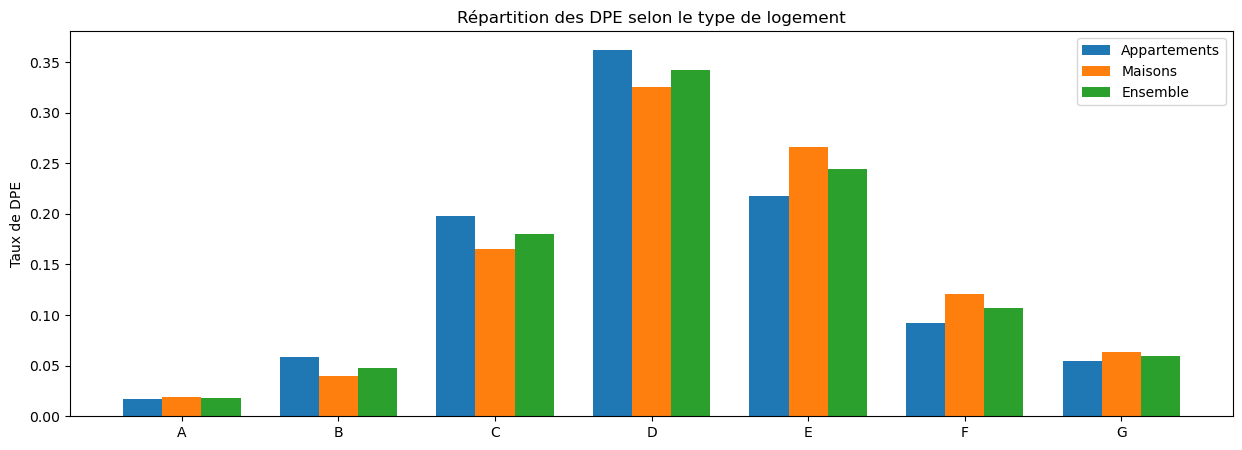

In [56]:
abscisse=['A','B','C','D','E','F','G']

#ci-dessous on traite les appartements, on passe par des listes pour pouvoir afficher tous les graphes sur une même ligne
dpe_app=df_log_nat_work.loc[[2]].values.tolist()
dpe_app=dpe_app[0]
dpe_app.remove('taux_app')
dpe_app.pop()

#ci-dessous on traite les maisons
dpe_maison=df_log_nat_work.loc[[5]].values.tolist()
dpe_maison=dpe_maison[0]
dpe_maison.remove('taux_maison')
dpe_maison.pop()

#ci-dessous l'ensemble
dpe_ens=df_log_nat_work.loc[[7]].values.tolist()
dpe_ens=dpe_ens[0]
dpe_ens.remove('taux_ens')
dpe_ens.pop()

x = np.arange(len(abscisse))  # localisation des labels
width = 0.25  # taille des barres

fig, ax = plt.subplots()
appart = ax.bar(x - width, dpe_app, width, label='Appartements')
maison = ax.bar(x, dpe_maison, width, label='Maisons')
ensemble = ax.bar(x + width, dpe_ens, width, label='Ensemble')

ax.set_ylabel('Taux de DPE')
ax.set_title('Répartition des DPE selon le type de logement')
ax.set_xticks(x,abscisse)
ax.legend()
fig.set_size_inches(15, 5)

plt.show()

#### Les maisons sont plus souvent classées comme énergivores

Un premier constat à effectuer est la répartition quasi normale des données de DPE, avec une queue de distribution plus importante pour les plus mauvais DPE (il y a relativement plus de F / G que de A / B).

Le second point d'intérêt est la meilleure isolation des appartements par rapport aux maisons (DPE des appartements plus performants en moyenne que ceux des maisons). 

Enfin, les maisons et appartements sont équiréparties pour chaque DPE (DPE "ensemble" à mi chemin entre appartement et maison).
La conséquence de cela est que les efforts de rénovation énergétiques ne doivent pas être polarisés sur les maisons ou les appartements mais bien sur les deux types de logement.

#### Quelles différences induites par des écarts de superficie ?

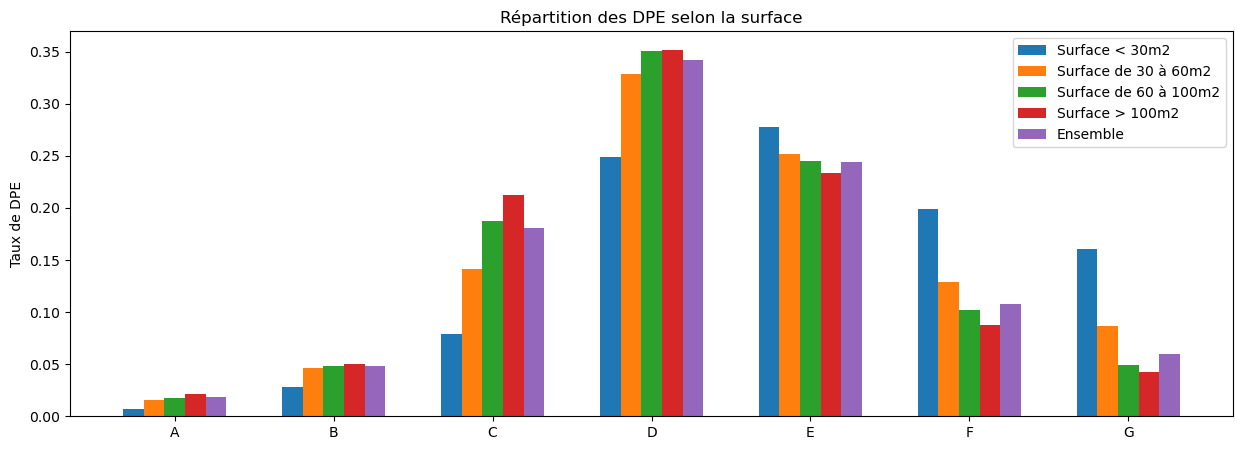

In [57]:
abscisse=['A','B','C','D','E','F','G']

#ci-dessous on va traiter par taille


#<30m2
dpe_inf30=df_log_nat_work.loc[[12]].values.tolist()
dpe_inf30=dpe_inf30[0]
dpe_inf30.remove('taux_<30m2')
dpe_inf30.pop()

#30-60m2
dpe_30a60m2=df_log_nat_work.loc[[15]].values.tolist()
dpe_30a60m2=dpe_30a60m2[0]
dpe_30a60m2.remove('taux_30-60m2')
dpe_30a60m2.pop()

#60-100m2
dpe_60a100m2=df_log_nat_work.loc[[18]].values.tolist()
dpe_60a100m2=dpe_60a100m2[0]
dpe_60a100m2.remove('taux_60-100m2')
dpe_60a100m2.pop()

#>100m2
dpe_sup100m2=df_log_nat_work.loc[[21]].values.tolist()
dpe_sup100m2=dpe_sup100m2[0]
dpe_sup100m2.remove('taux_>100m2')
dpe_sup100m2.pop()

#ci-dessous l'ensemble
dpe_ens=liste=df_log_nat_work.loc[[7]].values.tolist()
dpe_ens=dpe_ens[0]
dpe_ens.remove('taux_ens')
dpe_ens.pop()

x = np.arange(len(abscisse))  # localisation des labels
width = 0.13  # taille des barres

fig, ax = plt.subplots()
dpe_inf30= ax.bar(x - 2*width, dpe_inf30, width, label='Surface < 30m2')
dpe_30a60 = ax.bar(x -width, dpe_30a60m2, width, label='Surface de 30 à 60m2')
dpe_60a100= ax.bar(x, dpe_60a100m2, width, label='Surface de 60 à 100m2')
dpe_sup100 = ax.bar(x +width, dpe_sup100m2, width, label='Surface > 100m2')
ensemble = ax.bar(x + 2*width, dpe_ens, width, label='Ensemble')

ax.set_ylabel('Taux de DPE')
ax.set_title('Répartition des DPE selon la surface')
ax.set_xticks(x,abscisse)
ax.legend()
fig.set_size_inches(15, 5)

plt.show()

#### Les petites surfaces sont bien plus énergivores !

Le lien entre DPE et surface du logement semble suivre empiriquement une règle un peu contre-intuitive. On observe en effet que la distribution des DPE par surface du logement est meilleure lorsque les logements sont plus grands. 

On pourrait effectivement penser que plus les logements sont grands, plus ils sont énergivores et difficiles à isoler. Cependant, il est aussi probable que le pouvoir d'achat des détenteurs de plus grands logements soit plus important. Ce dernier leur permet donc d'investir davantage dans des travaux de rénovation énergétique ou de choisir un mode de chauffage plus économe en énergie lorsqu'ils possèdent une maison (pompe à chaleur hybride vs. chauffage au fioul). 

Ainsi, les logements les plus petits apparaissent comme moins bien isolés en moyenne.
L'étude par la suite des DPE par décile de revenu permettra de confirmer ou non l'origine économique de ce constat.

#### Les performances énergétiques différent-elles selon le statut d'occupation du logement ?

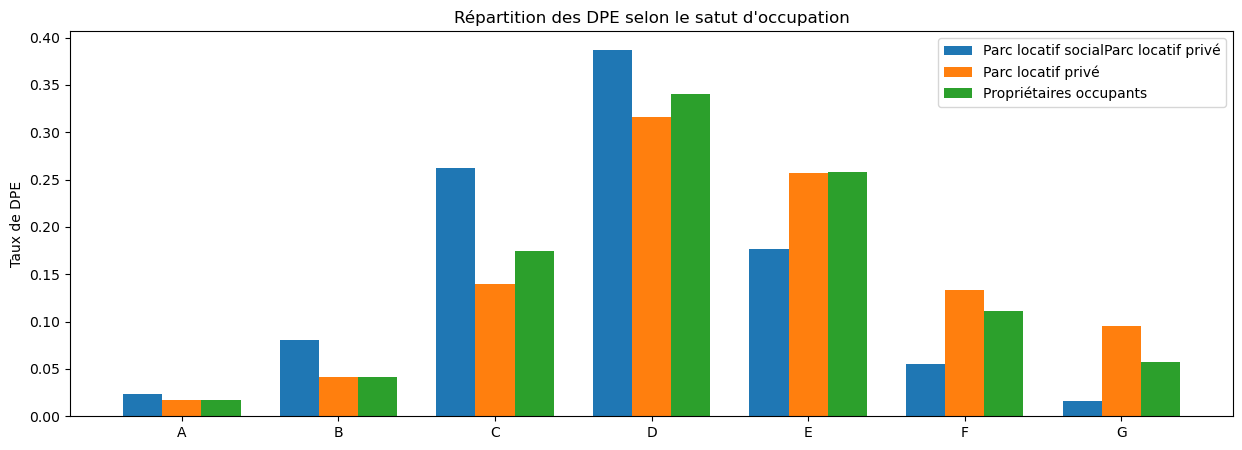

In [58]:
#ci-dessous, on va regarder si le statut d'occupation a également un impact ou non 

abscisse=['A','B','C','D','E','F','G']

#parc locatif privé 
loc_priv=df_hab_nat_work.loc[[8]].values.tolist()
loc_priv=loc_priv[0]
loc_priv.remove('taux_ens_locpriv')
loc_priv.pop()

#parc locatif social
loc_soc=df_hab_nat_work.loc[[17]].values.tolist()
loc_soc=loc_soc[0]
loc_soc.remove('taux_ens_locsoc')
loc_soc.pop()

#propriétaires occupants
proprio=df_hab_nat_work.loc[[26]].values.tolist()
proprio=proprio[0]
proprio.remove('taux_ens_proprio')
proprio.pop()

x = np.arange(len(abscisse))  # localisation des labels
width = 0.25  # taille des barres

fig, ax = plt.subplots()
loc_soc = ax.bar(x - width, loc_soc, width, label='Parc locatif socialParc locatif privé')
loc_priv = ax.bar(x, loc_priv, width, label='Parc locatif privé')
proprio = ax.bar(x + width, proprio, width, label='Propriétaires occupants')

ax.set_ylabel('Taux de DPE')
ax.set_title('Répartition des DPE selon le satut d\'occupation')
ax.set_xticks(x,abscisse)
ax.legend()
fig.set_size_inches(15, 5)

plt.show()

#### Les logements sociaux sont mieux classés en termes de performance énergétique 

Les locataires du parc social vivent plus fréquement dans des logements qui présentent un DPE plus important que la moyenne. Plus souvent classés B, C ou D, ils sont largement sous-représentés parmi les ménages qui vivent dans des passoires thermique. Cela s'explique probablement parce que, d'une part, le parc des logements sociaux est plus récent que le parc privé pris de manière globale. D'autre part, les bailleurs sociaux bénéficient d'aides importantes à la rénovations.

Les locataires du parc privé sont en revanche les plus mal lotis. Ils vivent notamment plus souvent dans des passoires thermique que ceux du parc social et que les propriétaires occupants. Par ailleurs, les locataires sont général des ménages moins favorisés que les propriétaires. De plus, la rénovation du logement incombe au propriétaire du bien. 
Ce constat justifie le ciblage de certaines politiques publiques, comme par exemple l'interdiction de la loction des logements les plus énergivores dans la loi climat. 

Les propriétaires occupant se situent dans une situation moins favorable, en termes de performance énergétique, que les locataires du parc social. Mais leur position apparait plus intermédiaire et moins précaire que celles des locataires du parc privé : ils habitent moins souvents dans des passoires thermique et plus souvent dans des logements "moyen" avec un DPE C ou D. 

Enfin, il est possible que l'emploi du logement (en location saisonnière ou en résidence principale par exemple) ait un impact sur les DPE, mais compte tenu des données disponibles, à ce stade, nous ne pouvons rien dire.

#### Quelles différences en fonction de la date de construction ?

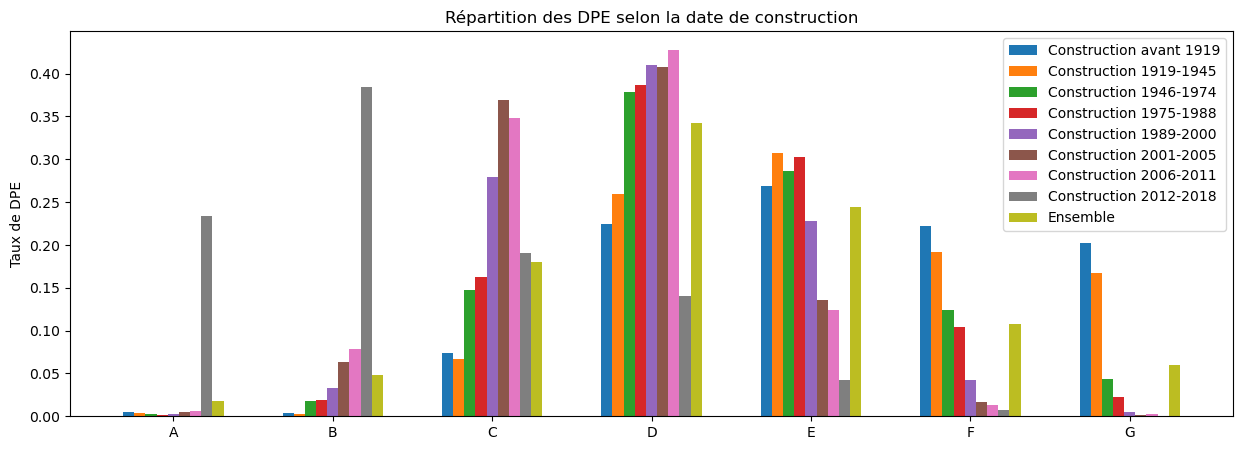

In [59]:
#ci-dessous, on se penche sur la date de construction du logement

abscisse=['A','B','C','D','E','F','G']


#date<1919
dpe_pre1919=df_log_nat_work.loc[[28]].values.tolist()
dpe_pre1919=dpe_pre1919[0]
dpe_pre1919.remove('taux_date<1919')
dpe_pre1919.pop()

#date 1919-1945
dpe_1919to1945=df_log_nat_work.loc[[31]].values.tolist()
dpe_1919to1945=dpe_1919to1945[0]
dpe_1919to1945.remove('taux_date1919-1945')
dpe_1919to1945.pop()

#date 1946-1974
dpe_1946to1974=df_log_nat_work.loc[[34]].values.tolist()
dpe_1946to1974=dpe_1946to1974[0]
dpe_1946to1974.remove('taux_date1946-1974')
dpe_1946to1974.pop()

#date 1975-1988
dpe_1975to1988=df_log_nat_work.loc[[37]].values.tolist()
dpe_1975to1988=dpe_1975to1988[0]
dpe_1975to1988.remove('taux_date1975-1988')
dpe_1975to1988.pop()

#date 1989-2000
dpe_1989to2000=df_log_nat_work.loc[[40]].values.tolist()
dpe_1989to2000=dpe_1989to2000[0]
dpe_1989to2000.remove('taux_date1989-2000')
dpe_1989to2000.pop()

#date 2001-2005
dpe_2001to2005=df_log_nat_work.loc[[43]].values.tolist()
dpe_2001to2005=dpe_2001to2005[0]
dpe_2001to2005.remove('taux_date2001-2005')
dpe_2001to2005.pop()

#date 2006-2011
dpe_2006to2011=df_log_nat_work.loc[[46]].values.tolist()
dpe_2006to2011=dpe_2006to2011[0]
dpe_2006to2011.remove('taux_date2006-2011')
dpe_2006to2011.pop()

#date 2012-2018
dpe_2012to2018=df_log_nat_work.loc[[49]].values.tolist()
dpe_2012to2018=dpe_2012to2018[0]
dpe_2012to2018.remove('taux_date2012-2018')
dpe_2012to2018.pop()

#ci-dessous l'ensemble
dpe_ens=liste=df_log_nat_work.loc[[7]].values.tolist()
dpe_ens=dpe_ens[0]
dpe_ens.remove('taux_ens')
dpe_ens.pop()

x = np.arange(len(abscisse))  # localisation des labels
width = 0.07  # taille des barres

fig, ax = plt.subplots()
dpe_pre1919= ax.bar(x - 4*width, dpe_pre1919, width, label='Construction avant 1919')
dpe_1919to1945= ax.bar(x - 3*width, dpe_1919to1945, width, label='Construction 1919-1945')
dpe_1946to1974= ax.bar(x - 2*width, dpe_1946to1974, width, label='Construction 1946-1974')
dpe_1975to1988= ax.bar(x - width, dpe_1975to1988, width, label='Construction 1975-1988')
dpe_1989to2000= ax.bar(x , dpe_1989to2000, width, label='Construction 1989-2000')
dpe_2001to2005= ax.bar(x +width, dpe_2001to2005, width, label='Construction 2001-2005')
dpe_2006to2011= ax.bar(x + 2*width, dpe_2006to2011, width, label='Construction 2006-2011')
dpe_2012to2018= ax.bar(x + 3*width, dpe_2012to2018, width, label='Construction 2012-2018')
ensemble = ax.bar(x + 4*width, dpe_ens, width, label='Ensemble')

ax.set_ylabel('Taux de DPE')
ax.set_title('Répartition des DPE selon la date de construction')
ax.set_xticks(x,abscisse)
ax.legend()
fig.set_size_inches(15, 5)

plt.show()

#### Les logements les plus récents ont un meilleur DPE !

Le lien entre DPE et date de construction semble plutôt logique : les logements les plus récents sont répartis davantages parmi les meilleurs DPE. On observe par exemple que pour les DPE F, la part de DPE F décroit strictement avec l'année de construction (~20% des logements construits avant 1919 et 1-2% des logements construits depuis 2012).

On observe par ailleurs une très impressionnante accélération des efforts d'isolation et de sobriété des logements avec ceux qui ont été construits de 2012 à 2018. Les étiquettes de DPE A et B représentent respectivement 23% et 38% des constructions durant cette période (moyenne de 2% pour les DPE A et 5% pour les DPE B).

Commençons par calculer le pourcentage de passoires thermiques dans chaque département.

In [60]:
df_bdd_nat_work=df_bdd_nat_work.assign(Taux_Passoires_Thermique=(df_bdd_nat_work['Taux_F']+df_bdd_nat_work['Taux_G'])*100)

## 2.1.2. L'étude de la région Occitanie, nous amène au constat XXXX sur le plan national

La précarité énergétique étant une problématique particulièrement saillante à l'heure actuelle, on souhaite, à l'échelle d'un département, visualiser comment sont isolés les ménages les plus pauvres et voir comment sont répartis les logements par DPE pour cette catégorie de population, et cela dans chaque département. On a choisi de s'intéresser à une ancienne région, Midi-Pyrénées, car on s'est rendu compte (lors de la partie cartographie, cf plus loin) qu'il y avait des disparités importantes en matière de DPE moyen entre les différents départements qui la composent. On s'intéresse tout d'abord aux ménages de déciles de revenu 1 à 3 et on fait ensuite de même pour les ménages des déciles de revenu 8 à 10.

@antoine, réorganiser la partie avec les sous titres :) 

#### Titre de conclusion 1 

#### Titre de conclusion 2 

On récupère, pour chaque département, les données sur les DPE par décile de revenu et on les rassemble en un seul tableau

@Antoine code traitement de données à remonter

In [61]:
ouverture = urlopen("https://www.statistiques.developpement-durable.gouv.fr/sites/default/files/2021-02/parc_par_departement_dpe_2018.zip") #on récupère le fichier zip par un lien
zipfile = ZipFile(BytesIO(ouverture.read())) #on crée une fonction qui lit le fichier zippé
nom=ZipFile.namelist(zipfile) #on trouve la liste de noms de fichiers (excel et txt) dont on se servira plus tard

for i in range(95):
  def extracted_file(i): #on crée une variable qui permet d'extraire un excel parmi la namelist
    return zipfile.open(nom[i]) #ouvre le département i, il faut aller de 1 jusqu'à 95 (nombre de départements étudiés, le fichier en position 0 étant un texte d'information)
  def lecture_excel(i):
    return pd.ExcelFile(extracted_file(i)) #on lit le fichier en tant qu'excel
  def tableau_revenus(i):
    return lecture_excel(i).parse('Revenus',skiprows=7 , nrows = 3, header = 0) #on crée un tableau en sélectionnant le contenu nécessaire

fichier_concatene = tableau_revenus(1)  #le premier élément
for i in range(2, 95):  
  fichier_concatene = pd.concat([fichier_concatene,tableau_revenus(i)]) #On regroupe le tableau 1 avec le 2, puis 1-2 avec 3, puis 1-2-3 avec 4 etc jusqu'à 95

fichier_concatene

,DEP,REVENUS,DPE A,DPE B,DPE C,DPE D,DPE E,DPE F,DPE G
0,1,D1 à D3,0.012017,0.050021,0.209944,0.304657,0.223262,0.108165,0.091933
1,1,D4 à D7,0.015256,0.059176,0.184939,0.301004,0.246305,0.111131,0.082188
2,1,D8 à D10,0.017854,0.058895,0.196102,0.316818,0.250504,0.098266,0.061560
0,2,D1 à D3,0.005713,0.025285,0.074525,0.249670,0.330824,0.189804,0.124179
1,2,D4 à D7,0.007339,0.028097,0.079050,0.271910,0.326661,0.184070,0.102874
...,...,...,...,...,...,...,...,...,...
1,94,D4 à D7,0.008177,0.042035,0.148175,0.422388,0.244891,0.086463,0.047871
2,94,D8 à D10,0.006376,0.031883,0.141822,0.427113,0.259833,0.091540,0.041433
0,95,D1 à D3,0.007058,0.043746,0.149566,0.373794,0.271765,0.094701,0.059369
1,95,D4 à D7,0.010143,0.048694,0.131316,0.360361,0.291348,0.104057,0.054081


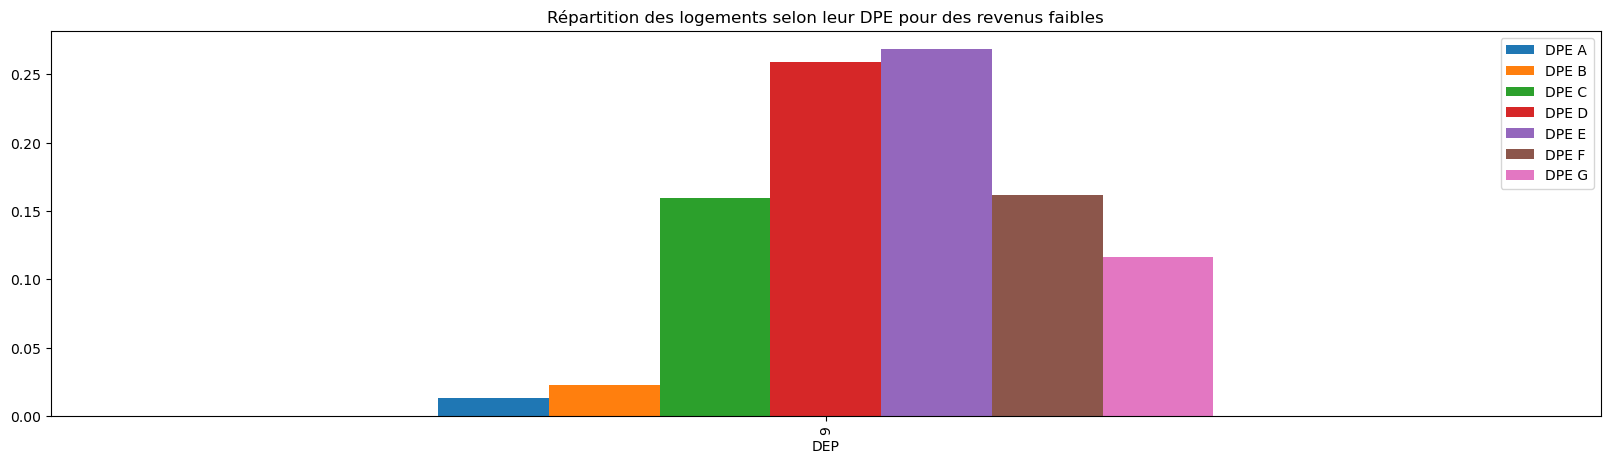

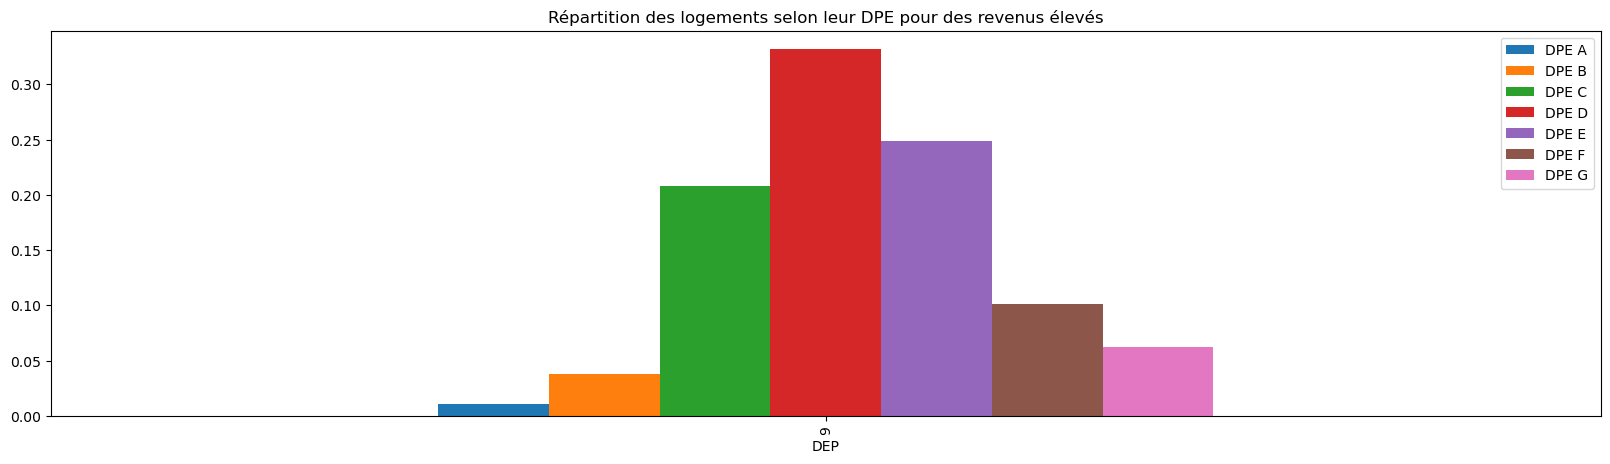

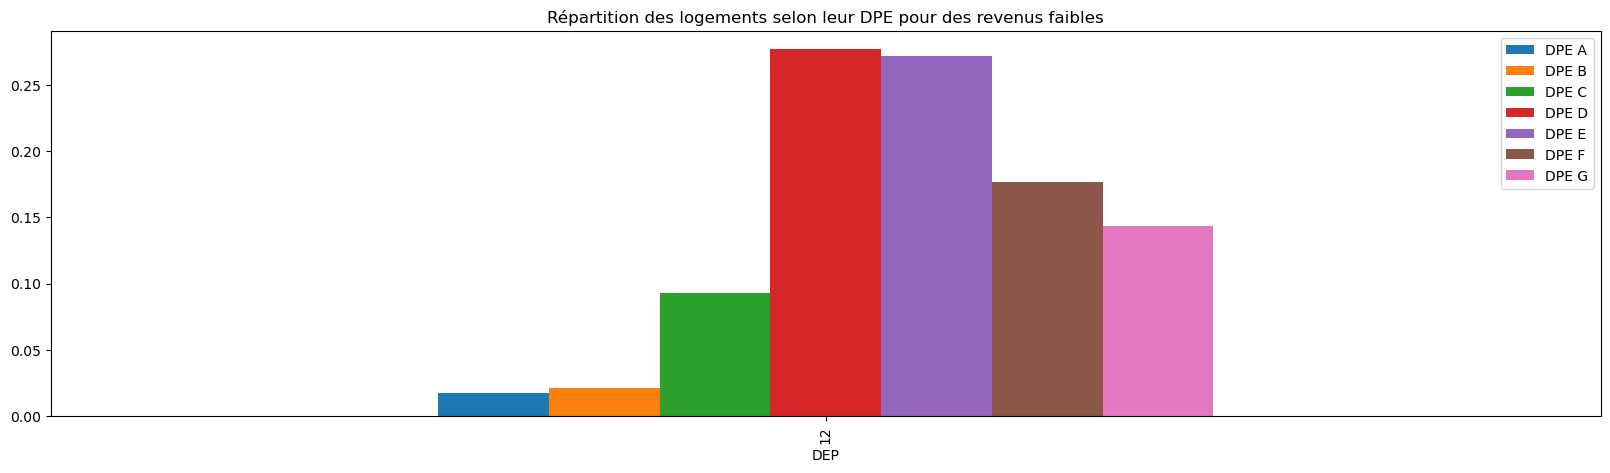

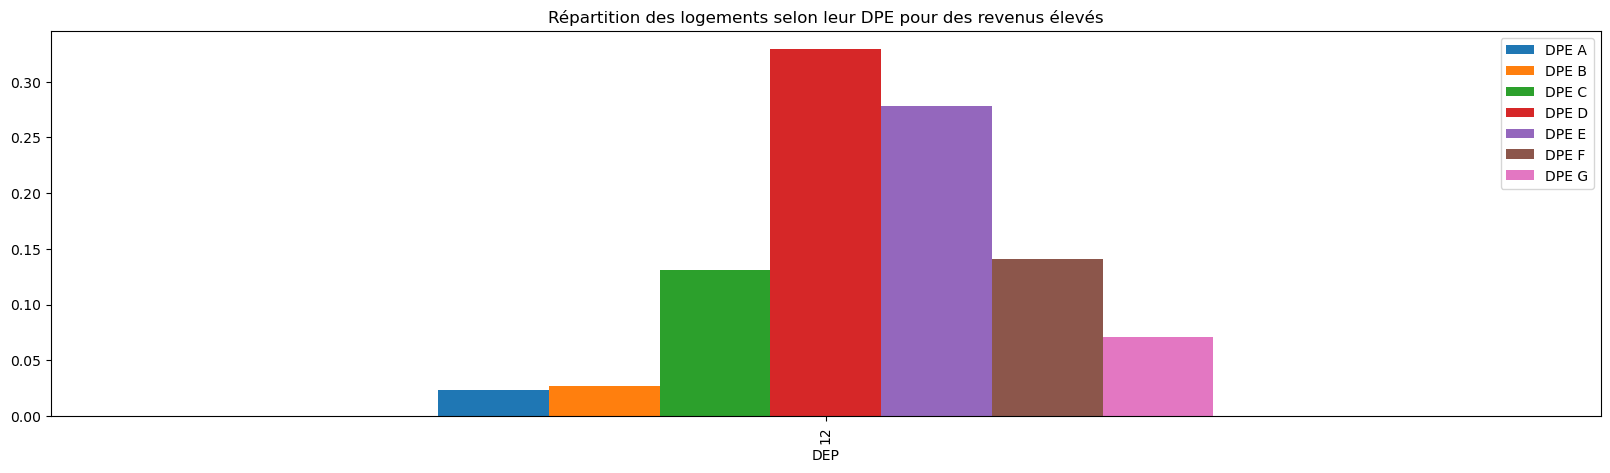

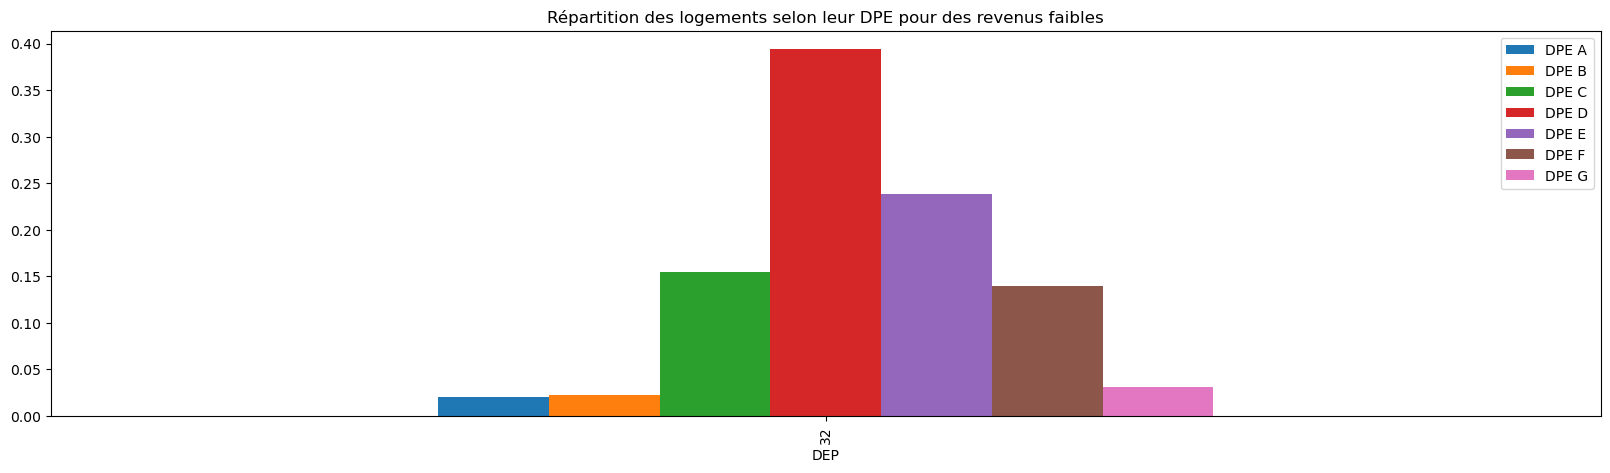

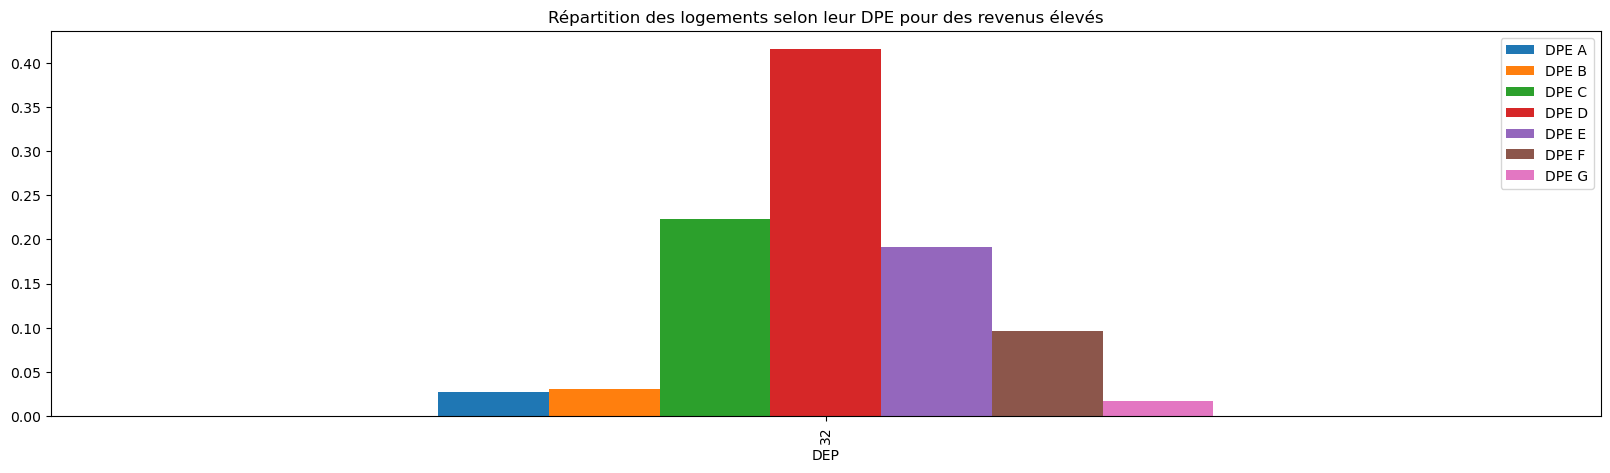

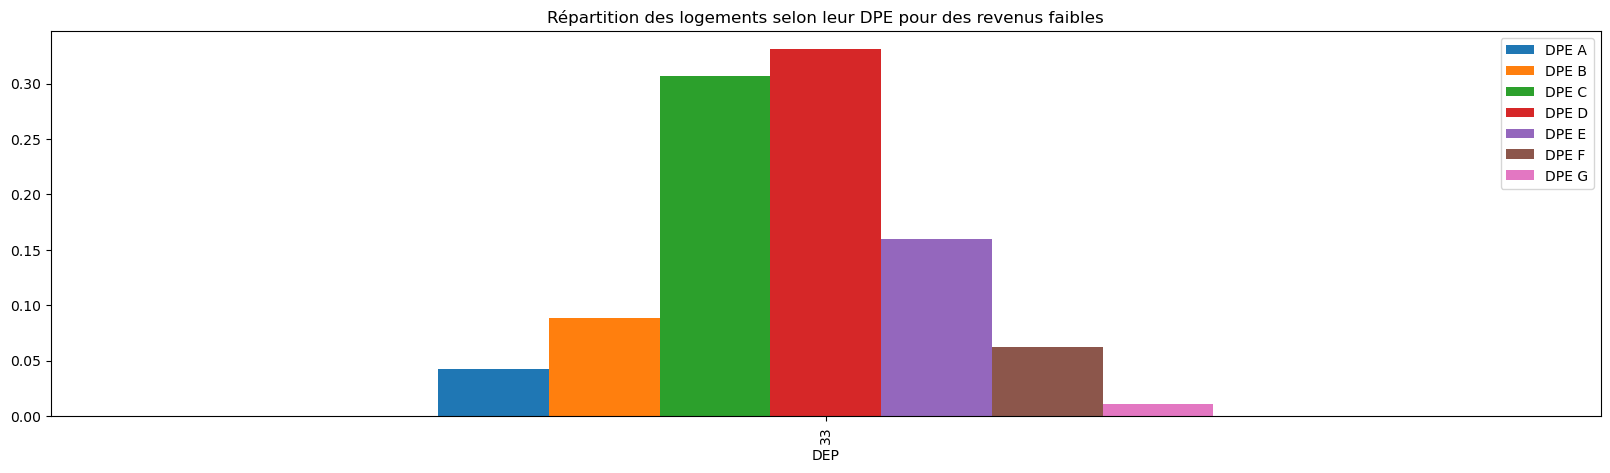

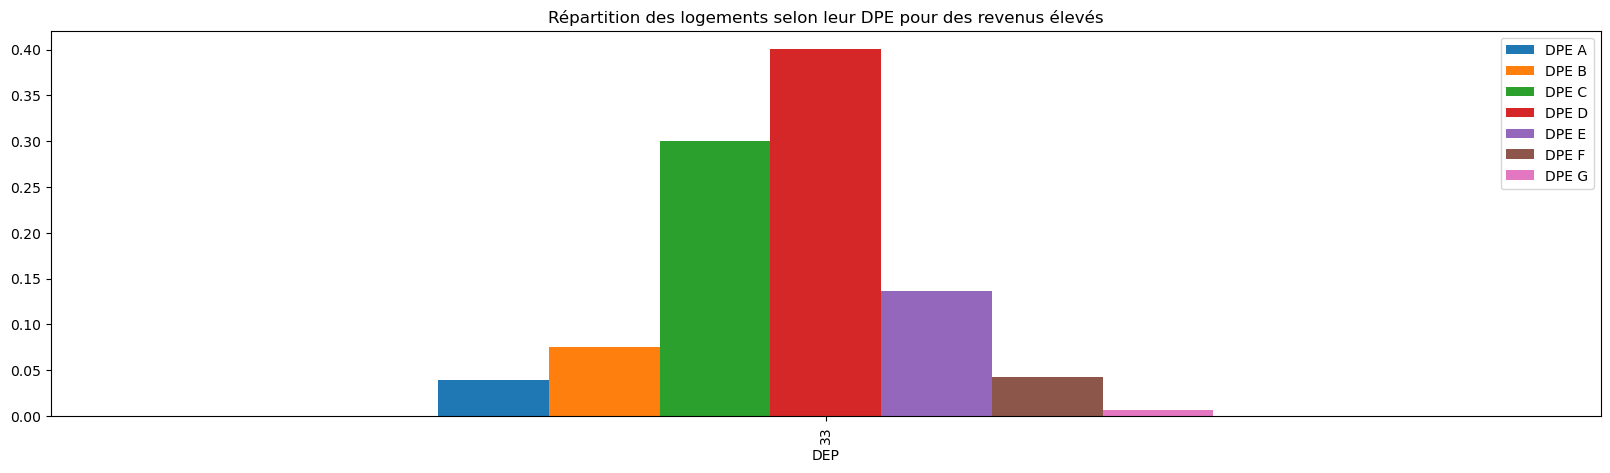

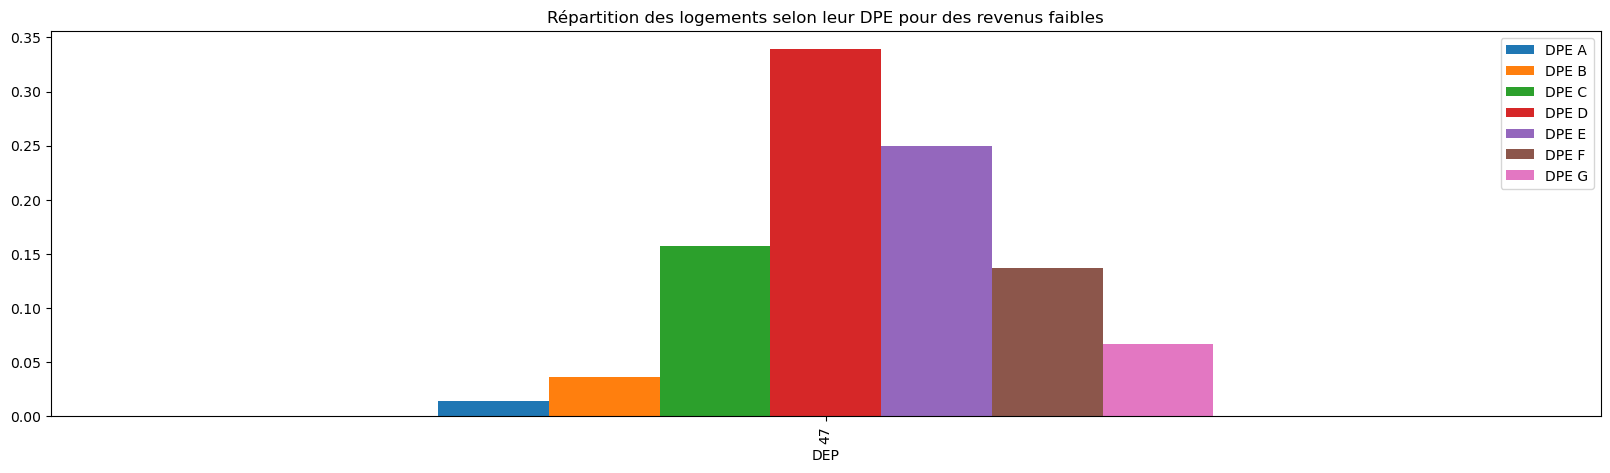

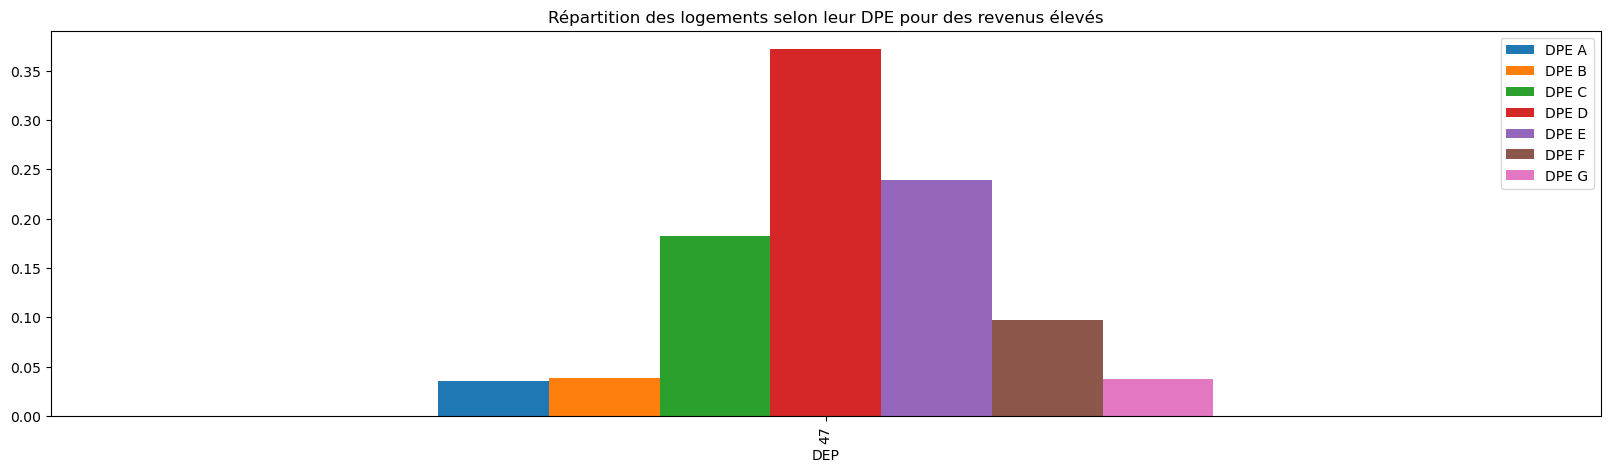

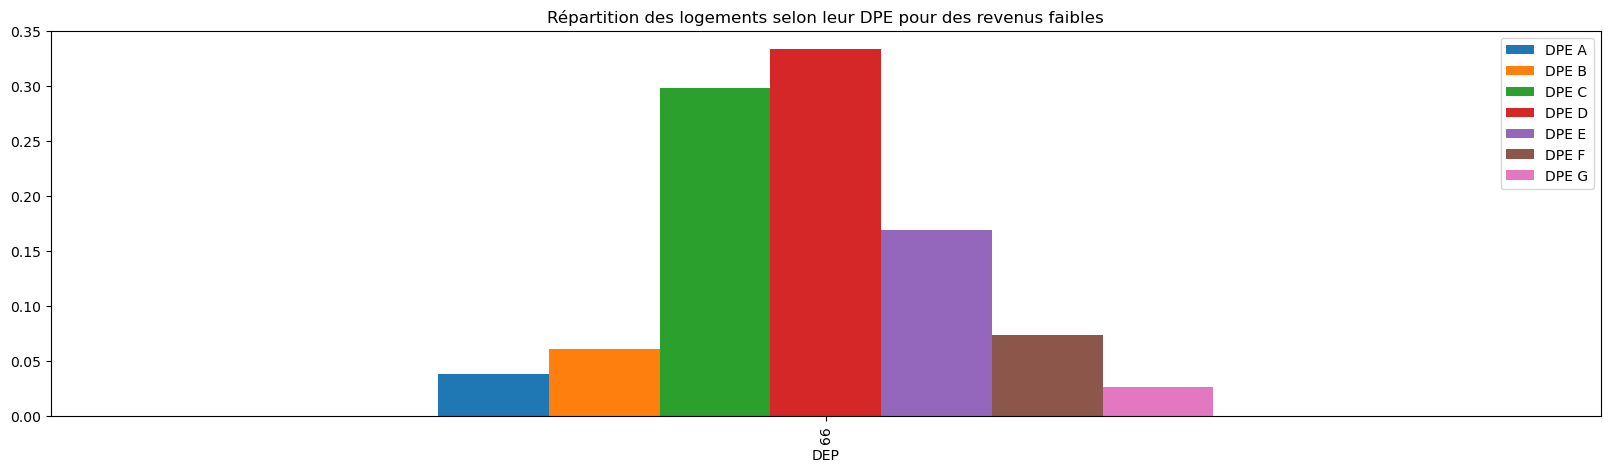

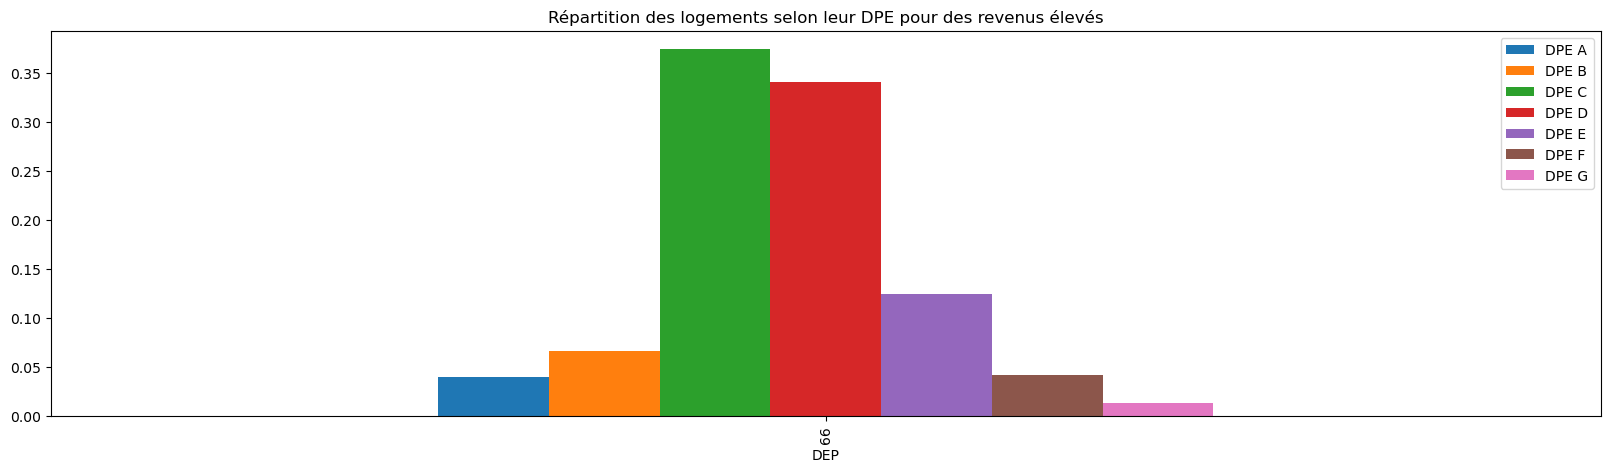

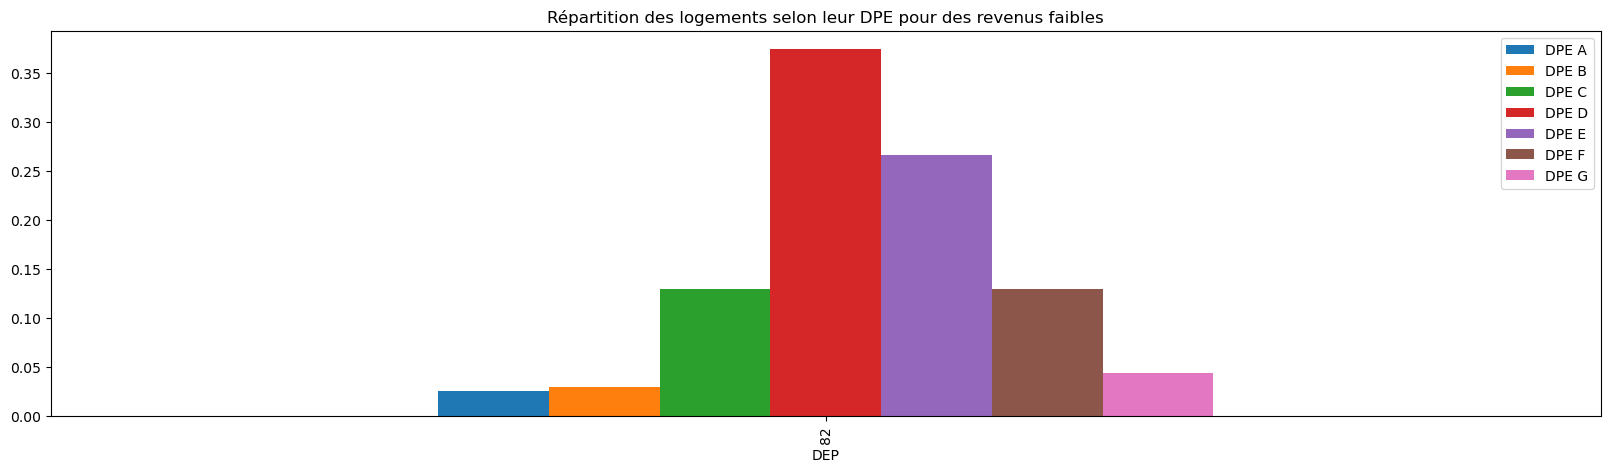

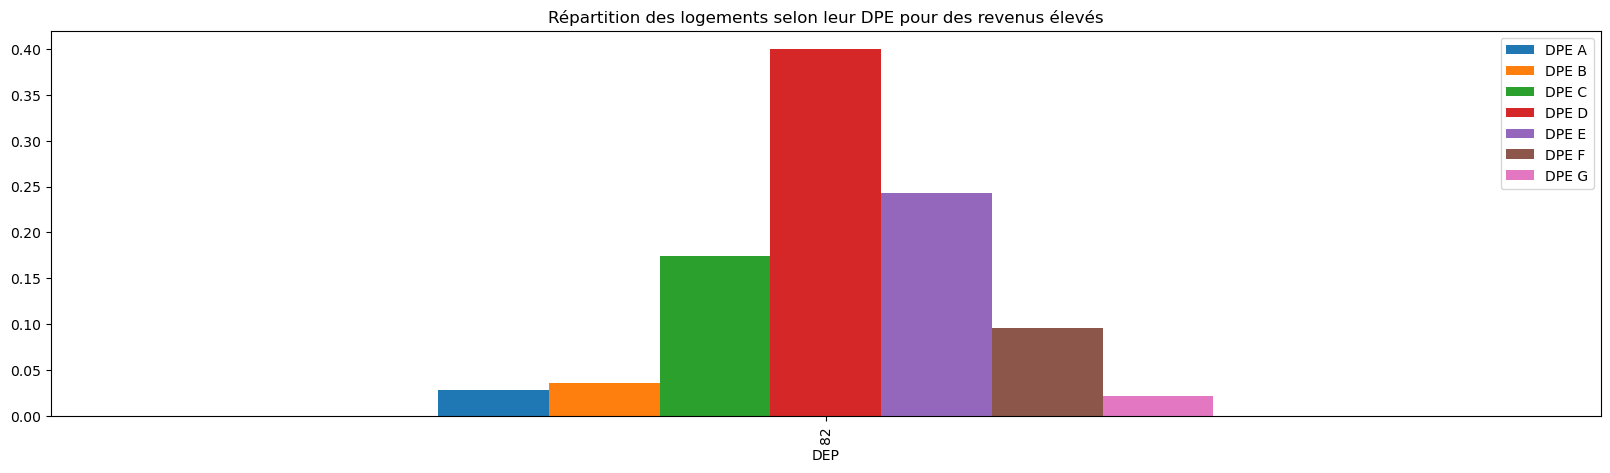

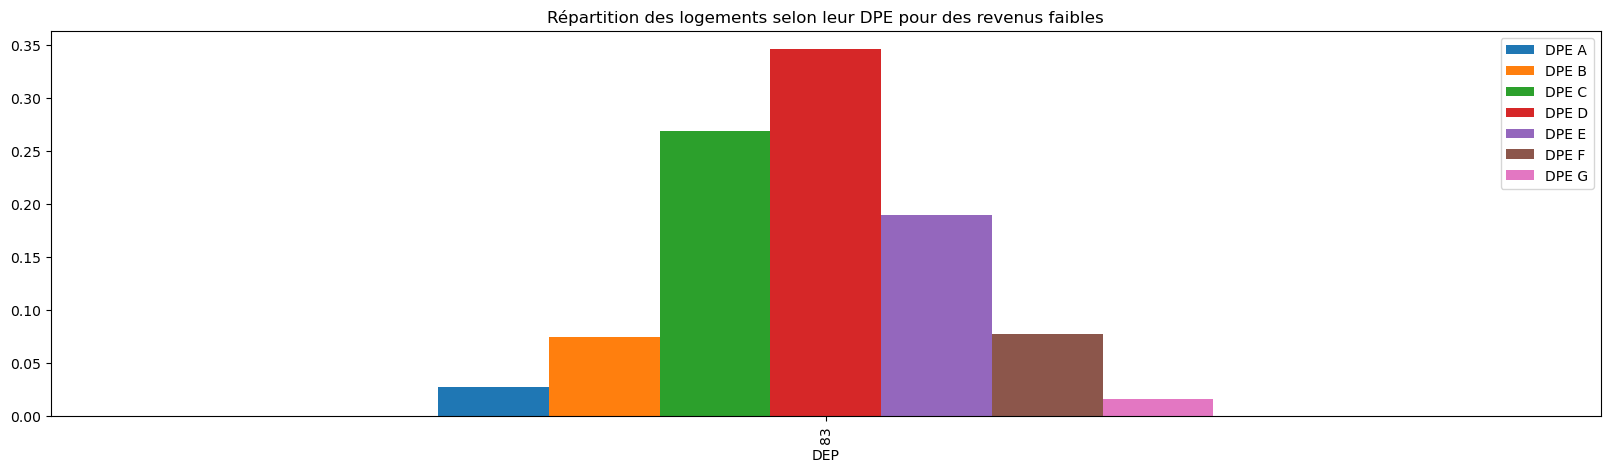

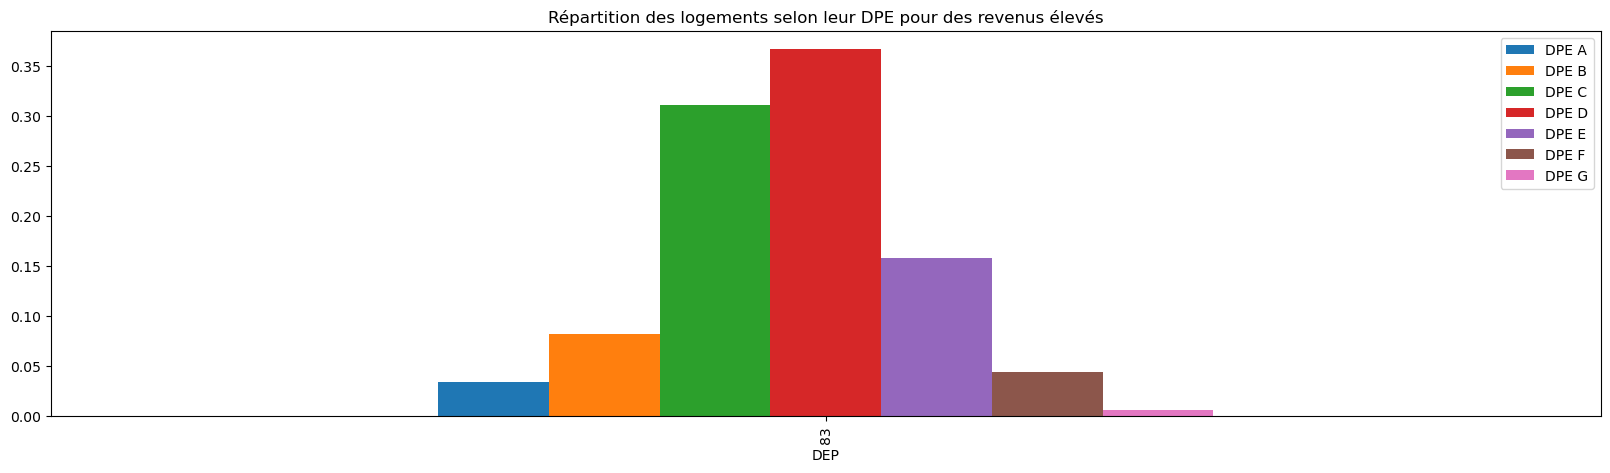

In [63]:
import matplotlib.pyplot as plt
liste_depatrtements=[9,12,31,32,46,65,81,82]
for i in liste_depatrtements:
  def df_DPE_revenu_eleve_departemental(i):
    return pd.DataFrame(data=tableau_revenus(i)[(tableau_revenus(i)['REVENUS'] == 'D8 à D10')],columns=['DEP','DPE A','DPE B','DPE C','DPE D','DPE E','DPE F','DPE G'])
  def graphique_DPE_revenu_eleve_departemental(i):
    return df_DPE_revenu_eleve_departemental(i).plot(x ='DEP', y=['DPE A','DPE B','DPE C','DPE D','DPE E','DPE F','DPE G'],kind = 'bar', figsize=(20,5), title="Répartition des logements selon leur DPE pour des revenus élevés")
  def df_DPE_revenu_faible_departemental(i):
    return pd.DataFrame(data=tableau_revenus(i)[(tableau_revenus(i)['REVENUS'] == 'D1 à D3')],columns=['DEP','DPE A','DPE B','DPE C','DPE D','DPE E','DPE F','DPE G'])
  def graphique_DPE_revenu_faible_departemental(i):
    return df_DPE_revenu_faible_departemental(i).plot(x ='DEP', y=['DPE A','DPE B','DPE C','DPE D','DPE E','DPE F','DPE G'],kind = 'bar', figsize=(20,5), title="Répartition des logements selon leur DPE pour des revenus faibles")
  plt.show(graphique_DPE_revenu_faible_departemental(i),graphique_DPE_revenu_eleve_departemental(i))

Tout d'abord, on constate des différences assez importantes entre départements, même si globalement la distribution des DPE suit la même logique. On se rend donc compte que chez les ménages les plus pauvres, la part de logements de DPE A ou B est extrêmement faible (environ 5% avec les deux catégories cumulées), tandis que la majorité des logements de cette catégories ont un DPE D ou E (environ 60% avec les deux catégories cumulées). Surtout, les logements classés F ou G représentent une part importante du parc, avec dans plusieurs départements plus d'un quart des logements avec un DPE F ou G. Il y a donc beaucoup à faire pour permettre à cette catégorie de ménages, la plus précaire, de mieux s'isoler.

On remarque pour cette catégorie de personnes que certains constats similaires peuvent se faire, à savoir peu de logements classés A et B et une grande majorité de C,D et E. Cependant, on constate que la part de passoires thermiques semble moins importante que chez les ménages plus pauvres, avec significativement moins de logements classés G notamment. C'est ce que l'on cherche à déterminer dans la prochaine partie.

Au niveau départemental, on cherche à affiner l'analyse et à savoir comment sont réparties les passoires thermiques selon certains critères. Le revenu parait pertinent pour étudier ces potentielles disparités. Ainsi, on construit ce que l'on pourrait appeler un indice d'inégalité en matière d'isolation thermique. En effet, on compare la proportion (en %) de personnes avec un revenu élevé (D8 à D10) habitant dans une passoire thermique de DPE G à celle ayant un revenu faible (D1 à D3) vivant aussi dans le même type de passoire thermique. On constate des différences importantes d'exposition aux passoires thermiques selon le revenu avec des disparités significatives selon les départements.



In [72]:
liste_indice=[]

for i in range(0,281,3):
  def rapport(i):
    A=fichier_concatene.iloc[i]['DPE G']
    B=fichier_concatene.iloc[i+2]['DPE G']
    C=A/B #pour un département i, on calcule le pourcentage de DPE G chez les personnes ayant un revenu faible divisé par celui chez celles ayant un revenu élevé
    return(C)
for j in range(0,281,3):
  liste_indice.append(rapport(j))

print(sum(liste_indice)/len(liste_indice)) #moyenne de la liste


departement_le_plus_inegalitaire = liste_indice.index(max(liste_indice))
departement_le_moins_inegalitaire = liste_indice.index(min(liste_indice))
print(departement_le_plus_inegalitaire)
print(departement_le_moins_inegalitaire)
print(max(liste_indice))
print(min(liste_indice))

1.6139808626612935
32
73
2.7446556643420656
0.9680283538618947


@antoine rajouter une phrase en print (voir partie François à la fin)

On crée un graphique représentant l'indice pour chacun des départements

Text(0, 0.5, 'indice inégalité')

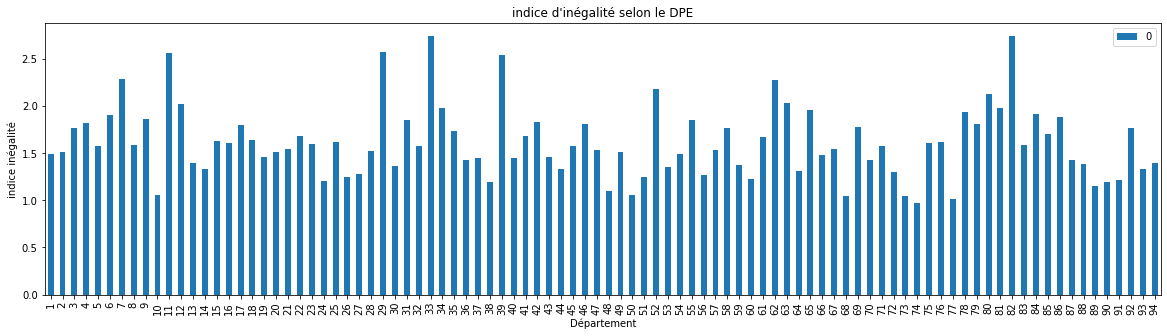

In [73]:
liste_indice
index=range(1,95)

y=pd.DataFrame(liste_indice, index)
y.plot(kind='bar', figsize=(20,5),title="indice d'inégalité selon le DPE")
plt.xlabel('Département')
plt.ylabel('indice inégalité')

@ANTOINE rajouter noms ci-dessus

Cet indicateur, comparable dans sa logique à un rapport interdécile, permet de mettre en évidence des disparités importantes au niveau départemental entre les plus hauts et les plus bas revenus en ce qui concerne le taux de passoires thermiques. En moyenne, sur les 94 départements, les ménages des déciles 1 à 3 sont 60% de plus que ceux des déciles 8-10 à vivre dans un logement de DPE G. Surtout, on remarque entre les départements des différences significatives. Ainsi, dans certains départements, il y a relativement peu d'écart concernant l'isolation entre revenus différents. Par exemple, le département 73+1 (Haute Savoie), où les ménages les plus pauvres (déciles 1-3) habitent même à peine moins (rapport de 0,97) dans des logements de DPE G que les plus riches (déciles 8-10). A l'inverse, certains départements sont beaucoup plus inégalitaires, à l'instar de la Gironde (32+1), où le rapport est de 2,74, soit donc près de trois fois plus inégalitaire que la Savoie.

Faisons un classement des meilleurs élèves

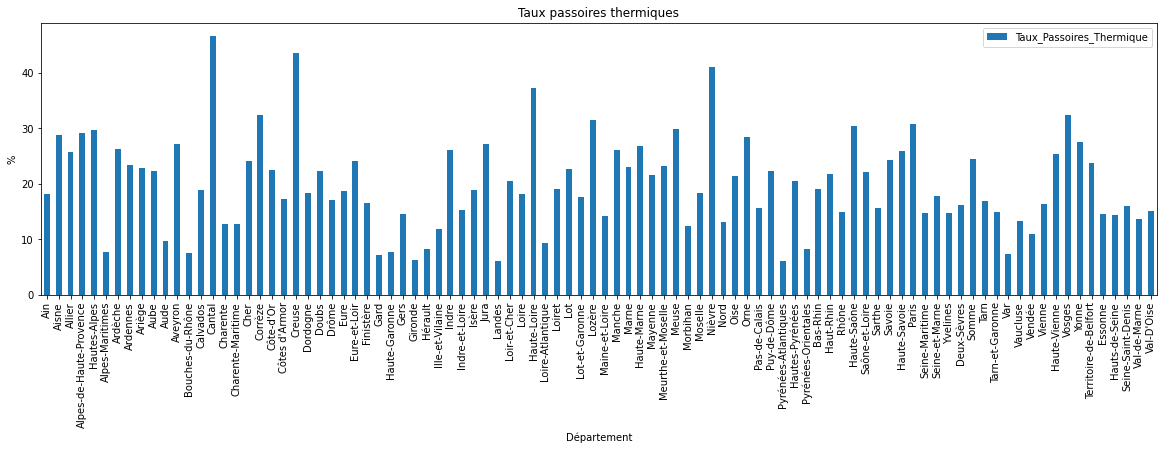

In [63]:
df_to_plot_2 = pd.DataFrame(df_bdd_nat_work,columns=['Département_nom','Taux_Passoires_Thermique'])
df_to_plot_2.plot(x ='Département_nom', y='Taux_Passoires_Thermique', kind = 'bar', figsize=(20,5), title="Taux passoires thermiques")
plt.xlabel('Département')
plt.ylabel('%')
plt.show()

Cette visualisation nous montre une forte disparité dans le pourcentage de passoires thermiques entre les différents départements. 
- Les départements les mieux lotis (Pyrénées-Atlantiques, Gironde, Bouches-du-Rhône...) n'ont que 7-8% de passoires thermiques. 
- A l'inverse, le Cantal, la Creuse ou la Nièvre ont plus de 40% de passoires thermiques

La section suivante (visualisation spatiale nationale) mettra en lumière ces disparités

## 2.2. Un peu de visualisation spatiale

On commence par importer ce qu'il nous faut

In [66]:
from cartiflette.download import get_vectorfile_ign

In [67]:
france = get_vectorfile_ign(
  level = "COMMUNE",
  field = "metropole",
  source = "EXPRESS-COG",
  provider="IGN"
  )

https://wxs.ign.fr/x02uy2aiwjo9bm8ce5plwqmr/telechargement/prepackage/ADMINEXPRESS_SHP_WGS84G_PACK_2022-06-21$ADMIN-EXPRESS_3-1__SHP__FRA_WM_2022-06-21/file/ADMIN-EXPRESS_3-1__SHP__FRA_WM_2022-06-21.7z


Downloading: : 563MiB [01:51, 5.28MiB/s] 
ERROR 1: PROJ: proj_create_from_database: Open of /opt/mamba/share/proj failed


Ici on va commencer à regrouper comme il nous faut les départements pour la visualisation spatiale

In [68]:
france.head(5)

,ID,NOM,NOM_M,INSEE_COM,STATUT,POPULATION,INSEE_CAN,INSEE_ARR,INSEE_DEP,INSEE_REG,SIREN_EPCI,geometry
0,COMMUNE_0000000009758097,Revest-du-Bion,REVEST-DU-BION,04163,Commune simple,525,11,4,04,93,200071025,"POLYGON ((5.49889 44.11605, 5.50191 44.11563, ..."
1,COMMUNE_0000000009758282,Simiane-la-Rotonde,SIMIANE-LA-ROTONDE,04208,Commune simple,602,11,4,04,93,200071025,"POLYGON ((5.51269 43.94531, 5.51210 43.94635, ..."
2,COMMUNE_0000000009742077,Fouesnant,FOUESNANT,29058,Commune simple,9864,11,4,29,53,242900660,"MULTIPOLYGON (((-3.98027 47.70376, -3.98026 47..."
3,COMMUNE_0000000009758063,La Bollène-Vésubie,LA BOLLENE-VESUBIE,06020,Commune simple,566,24,2,06,93,200030195,"POLYGON ((7.38016 43.96699, 7.38006 43.96707, ..."
4,COMMUNE_0000000009730910,Bairon et ses environs,BAIRON ET SES ENVIRONS,08116,Commune simple,1021,19,4,08,44,240800920,"POLYGON ((4.72192 49.55867, 4.72247 49.55917, ..."
5,COMMUNE_0000000009758061,Saorge,SAORGE,06132,Commune simple,458,10,2,06,93,240600551,"POLYGON ((7.41254 44.02116, 7.41245 44.02121, ..."
6,COMMUNE_0000000009753058,Genilac,GENILAC,42225,Commune simple,3894,10,3,42,84,244200770,"POLYGON ((4.55476 45.52693, 4.55488 45.52682, ..."
7,COMMUNE_0000000009731284,Voncq,VONCQ,08489,Commune simple,218,01,4,08,44,240800862,"POLYGON ((4.67835 49.45507, 4.67824 49.45504, ..."
8,COMMUNE_0000000009757466,Gaillac-d'Aveyron,GAILLAC-D'AVEYRON,12107,Commune simple,318,09,2,12,76,200068484,"POLYGON ((2.90445 44.32747, 2.90443 44.32751, ..."
9,COMMUNE_0000000009757289,Palmas d'Aveyron,PALMAS D'AVEYRON,12177,Commune simple,1017,09,2,12,76,200068484,"POLYGON ((2.89887 44.44869, 2.89880 44.44801, ..."


In [69]:
france['surface'] = france.area.div(10**6)

/tmp/ipykernel_95/2318629003.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  france['surface'] = france.area.div(10**6)


In [70]:
france_copy=france.dissolve(by='INSEE_DEP', aggfunc='sum')

/opt/mamba/lib/python3.10/site-packages/geopandas/geodataframe.py:1676: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggregated_data = data.groupby(**groupby_kwargs).agg(aggfunc)


In [71]:
france_copy.head(30) #on voit que la Corse est présente en bas du tableau, on va devoir l'enlever

,geometry,POPULATION,surface
INSEE_DEP,,,
01,"POLYGON ((4.84584 45.91236, 4.84568 45.91231, ...",652432,6.730689e-07
02,"POLYGON ((3.25491 48.96467, 3.25475 48.96559, ...",531345,9.210756e-07
03,"POLYGON ((2.66155 46.13692, 2.66147 46.13686, ...",335975,8.631625e-07
04,"POLYGON ((5.75607 43.73228, 5.75601 43.73239, ...",164308,7.863234e-07
05,"POLYGON ((5.75384 44.20950, 5.75378 44.20950, ...",141220,6.456304e-07
06,"MULTIPOLYGON (((6.93545 43.48428, 6.93540 43.4...",1094283,4.813684e-07
07,"POLYGON ((4.21024 44.29252, 4.20943 44.29265, ...",328278,6.326047e-07
08,"POLYGON ((4.23659 49.38138, 4.23655 49.38140, ...",270582,6.527259e-07
09,"POLYGON ((1.12853 42.75497, 1.12835 42.75516, ...",153287,5.414952e-07


In [72]:
#à ne compiler qu'une fois

france_copy.drop('2A',axis=0,inplace=True)
france_copy.drop('2B',axis=0,inplace=True)

# on a rendu son indépendance à la corse

In [73]:
france_copy #On a aussi une partie des DOM TOM 

,geometry,POPULATION,surface
INSEE_DEP,,,
01,"POLYGON ((4.84584 45.91236, 4.84568 45.91231, ...",652432,6.730689e-07
02,"POLYGON ((3.25491 48.96467, 3.25475 48.96559, ...",531345,9.210756e-07
03,"POLYGON ((2.66155 46.13692, 2.66147 46.13686, ...",335975,8.631625e-07
04,"POLYGON ((5.75607 43.73228, 5.75601 43.73239, ...",164308,7.863234e-07
05,"POLYGON ((5.75384 44.20950, 5.75378 44.20950, ...",141220,6.456304e-07
...,...,...,...
971,"MULTIPOLYGON (((-61.61055 15.83905, -61.61045 ...",384239,1.380582e-07
972,"MULTIPOLYGON (((-61.03809 14.44230, -61.03810 ...",364508,9.120589e-08
973,"MULTIPOLYGON (((-52.04398 3.54991, -52.04451 3...",281678,6.769642e-06


In [74]:
#à ne compiler qu'une fois

france_copy.drop('971',axis=0,inplace=True)
france_copy.drop('972',axis=0,inplace=True)
france_copy.drop('973',axis=0,inplace=True)
france_copy.drop('974',axis=0,inplace=True)
france_copy.drop('976',axis=0,inplace=True)

In [75]:
DPE_liste=df_bdd_nat_work['DPE_Moyen'].tolist() 
DPE_mode=df_bdd_nat_work['DPE_Mode'].tolist() 
quintile_log=df_bdd_nat_work['log_tot_quint'].tolist()
taux_pauvrete=donnees_filo_ind_departement_2019['TP6019'].tolist()
proportion_log_neuf=base_reg_inter['proportion_log_neuf'].tolist()
france_DPE = france_copy.assign(DPE=DPE_liste)
france_DPE = france_DPE.assign(DPE_mode=DPE_mode)
france_DPE = france_DPE.assign(quintile_logement=quintile_log)
france_DPE = france_DPE.assign(taux_pauvrete=taux_pauvrete)
france_DPE = france_DPE.assign(proportion_log_neuf=proportion_log_neuf)
france_DPE


,geometry,POPULATION,surface,DPE,DPE_mode,quintile_logement,taux_pauvrete,proportion_log_neuf
INSEE_DEP,,,,,,,,
01,"POLYGON ((4.84584 45.91236, 4.84568 45.91231, ...",652432,6.730689e-07,4.325929,D,5,0.107,0.101448
02,"POLYGON ((3.25491 48.96467, 3.25475 48.96559, ...",531345,9.210756e-07,4.862776,E,4,0.184,0.039756
03,"POLYGON ((2.66155 46.13692, 2.66147 46.13686, ...",335975,8.631625e-07,4.723923,D,3,0.154,0.027124
04,"POLYGON ((5.75607 43.73228, 5.75601 43.73239, ...",164308,7.863234e-07,4.778268,D,0,0.166,0.065274
05,"POLYGON ((5.75384 44.20950, 5.75378 44.20950, ...",141220,6.456304e-07,4.856483,E,0,0.139,0.061999
...,...,...,...,...,...,...,...,...
91,"POLYGON ((1.95984 48.30760, 1.95947 48.30769, ...",1301659,2.215381e-07,4.402458,D,8,0.133,0.075207
92,"POLYGON ((2.22879 48.77449, 2.22868 48.77451, ...",1624357,2.151563e-08,4.367739,D,9,0.119,0.050276
93,"POLYGON ((2.41754 48.84928, 2.41670 48.84925, ...",1644903,2.906464e-08,4.370616,D,9,0.279,0.079299


#### Les climats océaniques, plus doux et une forte densité, semblent favoriser l'obtention d'un meilleur DPE

Nous allons dans un premier temps visualiser la performance énergétique des logements à l'échelle départementale. Pour cela nous utilisons plusieurs indicateurs : le "DPE" moyen, la catégorie de DPE la plus fréquente dans le département 

<AxesSubplot: title={'center': "DPE Moyens à l'éhelle départementale, A=1, G=7"}>

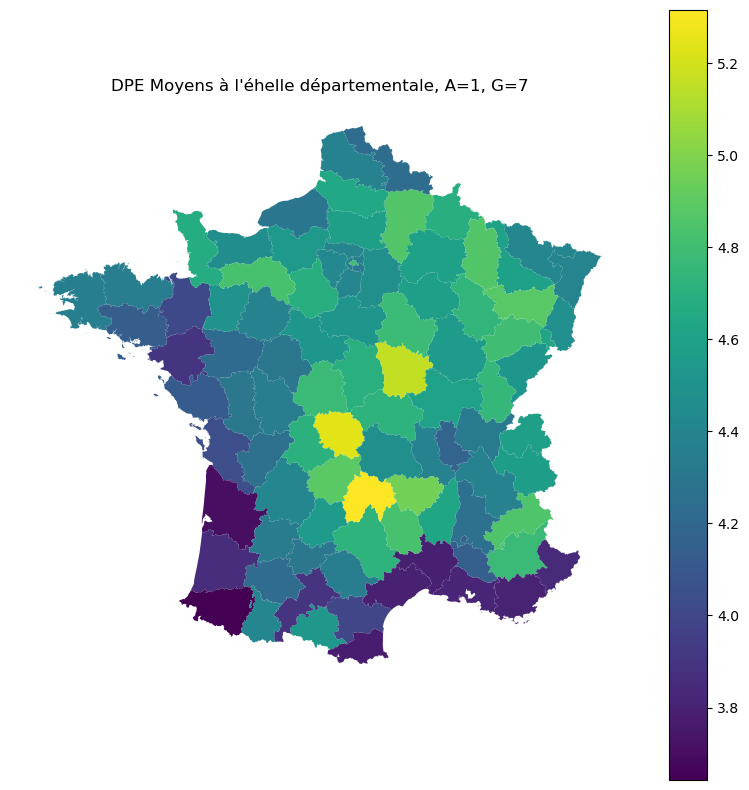

In [76]:
#Carte du score "DPE moyen"
fig,ax = plt.subplots(figsize=(10, 10))
france_DPE.plot(ax = ax, column = "DPE", legend=True)
ax.set_axis_off()
plt.title('DPE Moyens à l\'éhelle départementale, A=1, G=7')
ax

L'analyse spatiale par département permet de visualiser les inégalités terriroriales en termes de performance énergétique. En effet, l'étude du "DPE moyen" (voir score construit précédement) permet de mettre en évidence des différences entre départements : la côte méditérannéenne obtient les meilleurs scores, suivi par la côte atlantique. 
Le centre de la France, et plus largement la diagonale partant de la Meuse et s'étendant à la limite de la région Occitanie, présente les scores de DPE les plus élevés, soit les moins performants. Cette diagonale est souvent qualifié de diagonale "du vide", en raison de sa faible densité de population. La répartition du nombre de logement par département donne à voir cette plus faible densité de logements dans les départements dont le score est le moins performant. 

<AxesSubplot: title={'center': 'Densité de logements répartie par décile du nombre de logements et par département '}>

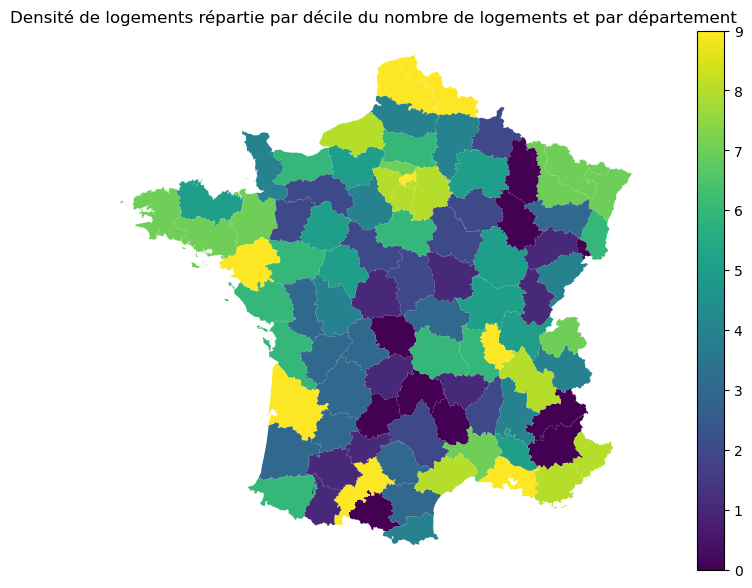

In [77]:
#Carte de la répartition des logements par départements 
fig,ax = plt.subplots(figsize=(10, 7))
france_DPE.plot(ax = ax, column = "quintile_logement", legend=True)
ax.set_axis_off()
plt.title('Densité de logements répartie par décile du nombre de logements et par département ')
ax

D'autres indicateurs produits à partir du DPE peuvent être intéressants. Le score au DPE par département ne permet pas de mettre en évidence la note de DPE la plus fréquente. Cette dernière illustre une autre dimension de la performance energétique et de la précarité de certains territoires, que la moyenne pondérée créée à partir de la note de DPE peut masquer. Par exemple, Paris était relativement mal classé à partir du score, alors que que la note la plus fréquente est D comme sur la très grande majorité du territoire. Par ailleurs, cela permet de mettre en évidence que les département de la Creuse et du Cantal, qui présentaient déjà un score très elevés, sont composés d'une majorité relative de logements classés "E". La performance energétique des logements y est donc très faible.

<AxesSubplot: title={'center': 'Note obtenue au DPE la plus fréquente par département'}>

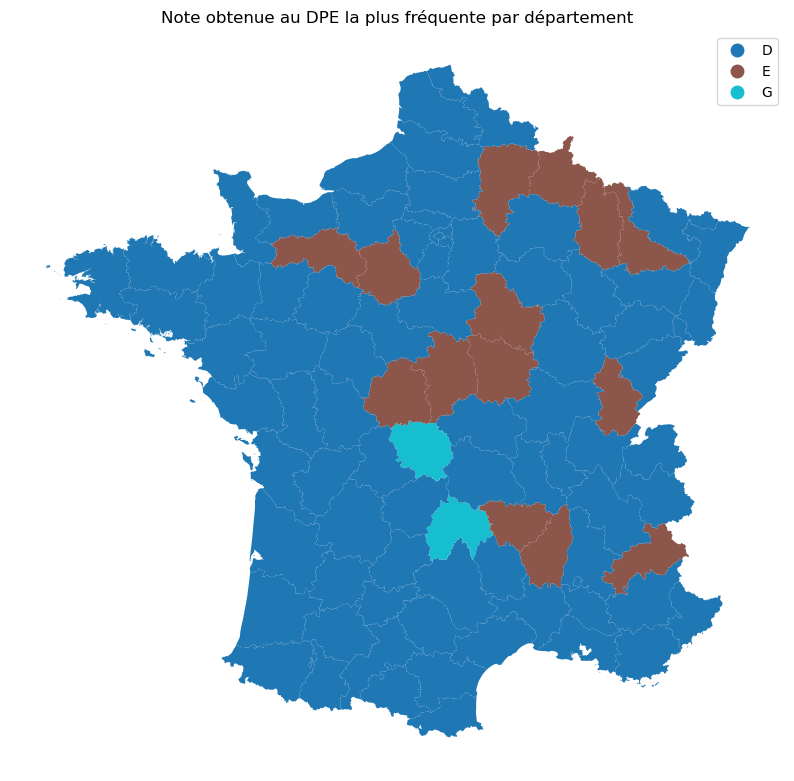

In [78]:
#carte du DPE le plus fréquent
fig,ax = plt.subplots(figsize=(10, 10))
france_DPE.plot(ax = ax, column = "DPE_mode", legend=True)
ax.set_axis_off()
plt.title('Note obtenue au DPE la plus fréquente par département')
ax

#### Les départements de la côte atlantique présente les proportions de logements neufs les plus elevés   

Les statistiques decriptives ont permis de mettre en évidence que la proportion de logements neufs est plus faible parmi les logements dont le DPE est mauvais. Après avoir étudié la répartition des logements sur le territoire, il peut être intéressant de visualiser la répartition des logements construits après 2012, et notamment leur proportion par départements. Densité et date de construction sont des variables probablement très liées dans la mesure où une forte densité peu pousser à construire plus de logements.

<AxesSubplot: title={'center': 'Proportion de logements neufs par département'}>

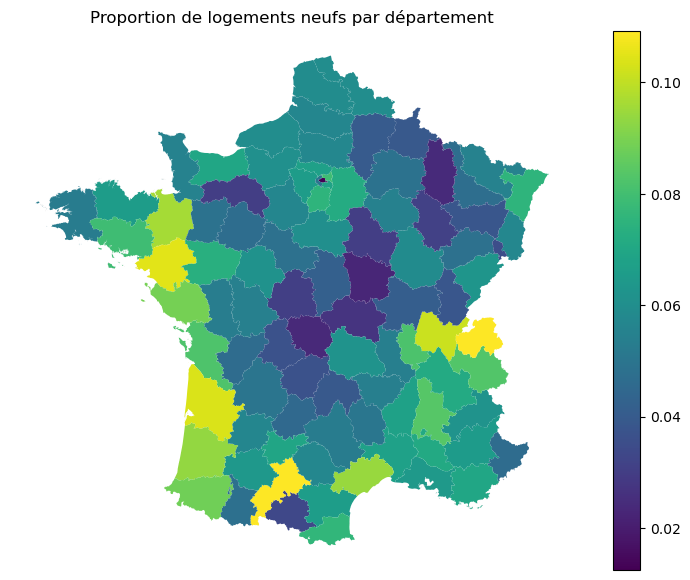

In [79]:
#Carte représentant la proportion de logement neuf par département
fig,ax = plt.subplots(figsize=(10, 7))
france_DPE.plot(ax = ax, column = "proportion_log_neuf", legend=True)
ax.set_axis_off()
plt.title('Proportion de logements neufs par département')
ax

In [80]:
mean = sum(france_DPE["proportion_log_neuf"])/len(france_DPE["proportion_log_neuf"])
print(mean)

0.059283232735817586


Ainsi, la proportion de logement neuf est plus importante sur la côte attlantique et pourrait expliquer en partie les meilleurs scores en termes de DPE. Au contraire, les départements où le nombre de logements les moins performants est elevé affiche une proportion de logements neufs très faible, de l'odre de moins de 2% de l'ensemble des logements. S'agissant de la côte méditerrannéene, la proportion de logements neufs dans les départements du littoral se situe au dessus de la moyenne mais ne présente pas un niveau aussi élevé que sur la côte atlantique.

#### Le taux de pauvreté au niveau départemental n'apparait pas comme directement lié à la perfomance energétique  

Nous avons ensuite cherché à introduire des varaibles socioéconomiques dans notre analyse. Le taux de pauvreté étant un indicateur intéressant du niveau de vie de la population pourrait avoir un lien avec la performance energitique des logements. En effet, le revenu des ménages avec un mauvais DPE est plus souvent plus faible comme présenté ci-dessus. 

<AxesSubplot: title={'center': 'Taux de pauvreté par département '}>

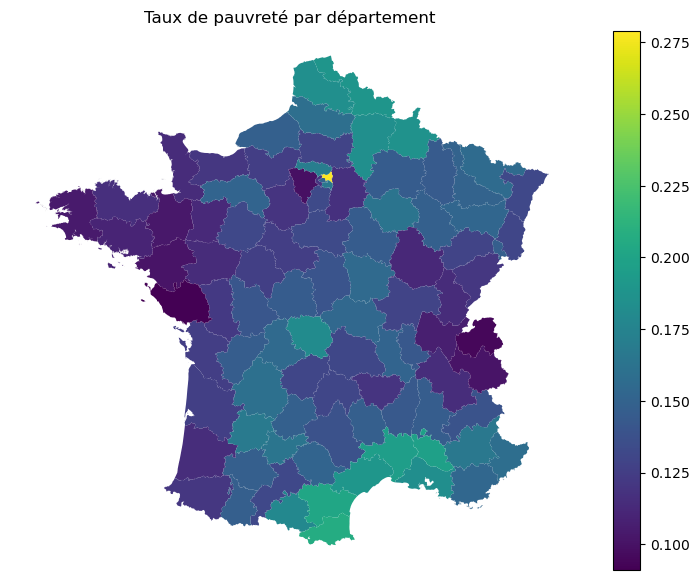

In [81]:
#Carte de la répartition du taux de pauvreté par départements 
fig,ax = plt.subplots(figsize=(10, 7))
france_DPE.plot(ax = ax, column = "taux_pauvrete", legend=True)
ax.set_axis_off()
plt.title('Taux de pauvreté par département ')
ax

Pourtant, le lien entre taux de pauvreté et mauvaise performance énergétique des logements n'apparait pas de façon claire lorsque l'on compare les cartes. En effet, si le taux de pauvreté est plus faible sur la côte atlantique, les département du pourtour méditerranéen présentent des taux de pauvreté plus élevés que le reste de la France. Une analyse "toutes choses égales par ailleurs" sera nécessaire pour évaluer plus précisément le lien entre les deux.

#### Des passoires thermiques qui semblent davantage distribuées en fonction de la proportion de logements neufs que de la pauvreté des ménages

In [84]:
passoires=df_bdd_nat_work['Taux_Passoires_Thermique'].tolist() 
france_passoires = france_copy.assign(passoires=passoires)
france_passoires

,geometry,POPULATION,surface,passoires
INSEE_DEP,,,,
01,"POLYGON ((4.84584 45.91236, 4.84568 45.91231, ...",652432,6.730689e-07,18.219730
02,"POLYGON ((3.25491 48.96467, 3.25475 48.96559, ...",531345,9.210756e-07,28.873883
03,"POLYGON ((2.66155 46.13692, 2.66147 46.13686, ...",335975,8.631625e-07,25.744696
04,"POLYGON ((5.75607 43.73228, 5.75601 43.73239, ...",164308,7.863234e-07,29.176637
05,"POLYGON ((5.75384 44.20950, 5.75378 44.20950, ...",141220,6.456304e-07,29.757824
...,...,...,...,...
91,"POLYGON ((1.95984 48.30760, 1.95947 48.30769, ...",1301659,2.215381e-07,14.624251
92,"POLYGON ((2.22879 48.77449, 2.22868 48.77451, ...",1624357,2.151563e-08,14.376621
93,"POLYGON ((2.41754 48.84928, 2.41670 48.84925, ...",1644903,2.906464e-08,15.940095


<AxesSubplot: title={'center': 'Taux de passoires thermiques'}>

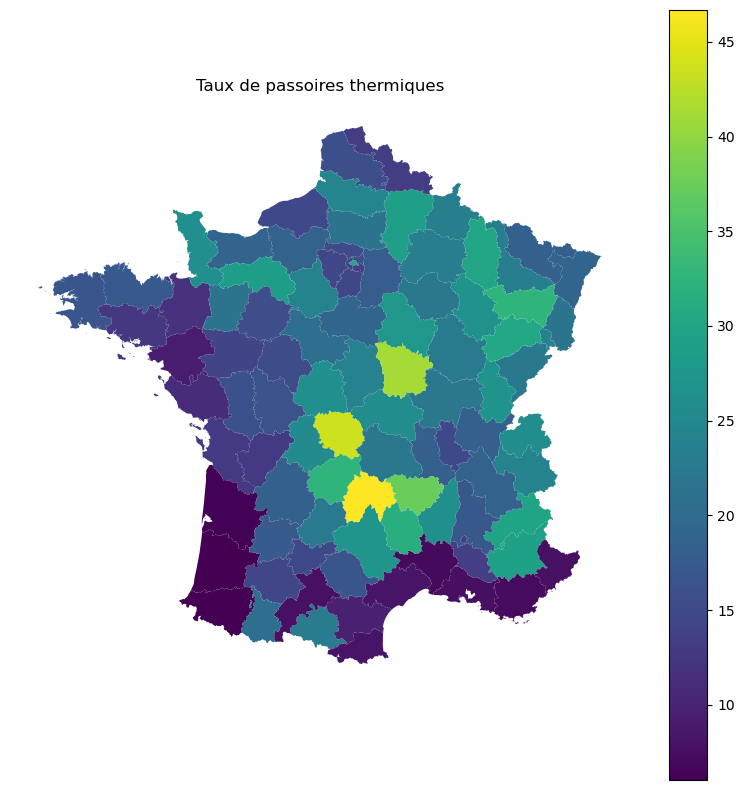

In [85]:
fig,ax = plt.subplots(figsize=(10, 10))
france_passoires.plot(ax = ax, column = "passoires", legend=True)
ax.set_axis_off()
plt.title('Taux de passoires thermiques')
ax

En cohérence avec les analyses précédentes, la proportion de passoire thermique est très faibles dans les départements situés sur les côtes françaises et plus elevés sur la diagonale qui traverse d'est en ouest, en particulier, dans les départements de la Meuse et du Cantal, près d'un logement sur deux peut être qualifiés de passoire thermique.

# 3. Modélisation 

## 3.1. Algorithme de prédiction des DPE
### 3.1.1. Les déciles de revenus et le département prédisent peu le DPE

Nous avons préparé en 1.2.2 notre base de données pour faire notre prédiction de DPE à partir des répartitions de revenus des habitants. Nous allons utiliser un algo de classification, random forest, pour tenter de voir si ces facteurs permettent suffisamment d'expliquer le DPE.

In [ ]:
#on définit les X et Y
X = base_pred.drop(["DPE", "DPE_encodé"], axis=1)
y = base_pred["DPE_encodé"]
X

On fixe un train test de 70%.

In [ ]:
#on applique le modèle et on sépare entre train et test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=44)
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=50, max_features="auto", random_state=44)
rf_model.fit(X_train, y_train)

In [ ]:
#calculons la précision et l'importance relative des facteurs

predictions = rf_model.predict(X_test)
predictions

#calculons la précision

difference=predictions-y_test

#quel est le nombre de bonnes prédictions?
vrai_positif=difference.value_counts(dropna=False)[0]
précision=vrai_positif/len(difference)
précision=round(précision*100,2)
precision_to_print=str(précision)
print("La précision est de "+precision_to_print+"%")

#quelle est la feature importance ?

importances=rf_model.feature_importances_
columns=X.columns
i=0

while i<len(columns):
    print(f"L'importance de '{columns[i]}' est {round(importances[i]*100,2)}%")
    i=i+1


On peut constater que la prédiction est assez mauvaise et il n'existe pas un facteur explicatif qui se détache. 
Le département semble assez peu séparer les différents DPE, ce qui était attendu.

Par la suite, on va essayer d'utiliser à nouveau un algorithme de classification mais cette fois-ci pour prévoir les passoires thermiques.

### 3.1.2. Les revenus extrêmes sont utiles pour prédire le caractère de passoire thermique

In [ ]:
#on définit les X et Y
X2 = base_pred.drop(["DPE", "DPE_encodé","passoire"], axis=1)
y2 = base_pred["passoire"]
X2

In [ ]:
#on applique le modèle et on sépare entre train et test
from sklearn.model_selection import train_test_split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=44)
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=50, max_features="auto", random_state=44)
rf_model.fit(X_train2, y_train2)

In [ ]:
#calculons la précision et l'importance relative des facteurs

predictions2 = rf_model.predict(X_test2)
predictions2

#calculons la précision

count=0
for i in range(len(y_test2)):
    if y_test2.iloc[i]==predictions2[i]:
        count=count+1

précision2=round((count/len(y_test2))*100,2)
precision_to_print2=str(précision2)
print("La précision est de "+precision_to_print2+"%")

#quelle est la feature importance ?

importances2=rf_model.feature_importances_
columns2=X2.columns
i=0

while i<len(columns2):
    print(f"L'importance de '{columns2[i]}' est {round(importances2[i]*100,2)}%")
    i=i+1

Cependant, la précision est forte mais cela est du au grand nombre de zéros qui sont présents dans les valeurs à prédire (toutes les classes qui ne sont pas des passoires thermiques). Une mesure plus pertinente pour notre algorithme est de mesurer le taux de vrai positifs. Nous le faisons après.
Nous pouvons par ailleurs remarquer que les déciles les plus extrêmes ont un meilleur pouvoir séparateur des arbres avec une importance accrue, cela souligne une corrélation entre inégalités de logements et de revenus. 

In [ ]:
#calculons le taux de vrai positifs

count=0
for i in range(len(y_test2)):
    if y_test2.iloc[i]==predictions2[i]==1:
        count=count+1
real_positives=np.sum(y_test2)
real_positives=round((count/real_positives)*100,2)
print("Le taux de vrai positifs est "+str(real_positives)+"%")

## 3.2. Analyse des déterminants de la proportion de passoire thermique par départements à partir d'une régression linéaire

### 3.2.1. La proportion de logement neuf est liée négativement à la part de passoire thermique à caractéristiques socioéconomiques contrôlées. 
Les statistiques decriptives ont permi de mettre en avant des corrélations possibles entre des variables sociodémographiques et la proportion de passoire thermique au niveau départemental. Afin d'évaluer ces corrélations, et sans considérer qu'il existe une causalité directe, nous allons réaliser une regression linéaire. 

Le modèle s'écrit : 

Proportion de passoires thermiques dans le département = constante + β1 * %de personnes pauvre dans le département + β2 * %de logement neuf + β3 * nombre de logement + β4 * %de grand logement + β4 * %de petit logement + β5 * %de personnes imposables + β6 * %de propriétaires occupants + β6 * %de locataire du parc social

In [ ]:
base_reg_fin.columns 

In [ ]:
X = base_reg_fin[['TP6019','proportion_log_neuf' , 'total_log_dep', 'proportion_log_grand',
       'proportion_log_petit','PIMP19','proportion_proprietaires',
       'proportion_log_soc']]
X = sm.add_constant(X) # on ajoute une constante
y = base_reg_fin["proportion_pass_therm"]

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

Les résultats de la régression sont intéressants à plusieurs égards. 

Le modèle parait relativement pertinent pour décrire et tenter d'expliquer la part de passoire thermique dans les départements, ainsi les tests statistiques confirment que certaines variables ont une influence non négligeable sur la proportion de logements énergivores et le R2 ajusté du modèle est relativement bon, notamment pour une analyse sociodémographique. 

Les variables les plus liées à la proportion de passoire thermique sont, par ordre d'importance, la proportion de logements neufs, le taux de pauvreté et la proportion de logements grands. L'effet est toujours significativement négatif à 5%, voire 1% dans le cas des logements neufs. Ainsi, le fait d'avoir une proportion de passoire thermique plus importante dans un département qu'un autre est principalement liée à la faiblesse du nombre de logements neufs et grands (plus de 120m2). Le lien avec le taux de pauvreté est plus ambigu, en l'état une augmentation du taux de pauvreté serait négativement lié avec une augmentation du nombre de passoire thermique, mais si ce résultat est intéressant, il nécessiterait une analyse plus poussée car il reflète probablement un biais de variables omises. Enfin, le coefficient associé à la densité de logements est significatif à 1% également mais étant très faible, l'effet est presque négligeable.   

Par ailleurs, le modèle permet de mettre en évidence que certaines variables qui paraissaient liées aux logements énergivores en statistiques decriptives ne sont a priori pas les plus déterminantes une fois prise en compte d'autres variables explicatives, par abus de language "toutes choses égales par ailleurs". En effet, la part des logement sociaux par exemple n'apparait pas significativement liée à la proportion de passoire thermique, il en est de même pour les logements petits. Dans une perspective de mise en place de politique publique, il est intéressant de noter que la part de ménages imposés fiscalement n'a pas non plus de lien évident avec la part de logements énergivores. La politique fiscale n'est donc pas nécessairement l'outil qui serait le plus pertinent pour réduire la proportion de ces logements. 

Nous allons cependant faire quelques régressions supplémentaires qui pourront servir à préciser l'analyse et à tester la robustesse de ces résultats. 

### 3.2.2. Test de robustesse & parcimonie du modèle

Une façon simple de tester la robustesse des résultats (outre le contrôle des tests statistiques habituels) est de réaliser plusieurs régressions en faisant varier les variables explicatives. Nous allons ainsi chercher à voir dans quelle mesure les variables qui ressortent dans le modèle long le sont toujours quelque soit le modèle spécifié. Nous regarderons également si certaines variables deviennent significatives dans des modèles plus courts. Enfin, nous porterons une attention particulière au R2 afin de voir si les variables les plus explicatives permettent de conserver un modèle de qualité. 

In [ ]:
X = base_reg_fin[['TP6019','proportion_log_neuf' , 'total_log_dep', 'proportion_log_grand']]
X = sm.add_constant(X) # on ajoute une constante
y = base_reg_fin["proportion_pass_therm"]

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

Ce modèle court conserve uniquement les variables significatives. Le R2 reste bon et les coefficients des variables ont peut changés. 

In [ ]:
X = base_reg_fin[['TP6019','proportion_log_neuf' ,  'proportion_log_grand']]
X = sm.add_constant(X) # on ajoute une constante
y = base_reg_fin["proportion_pass_therm"]

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

Dans ce modèle nous avons retiré la variable relative aux nombres de logements, le coefficient associé étant presque négligeable. Dans ce contexte, on constate que la proportion de grands logements n'est plus significative. Son pouvoir explicatif est donc dépendant de la densité de logements c'est à dire que la surface du logement n'aurait une importance significative qu'à densité égale. Le R2 carré reste bon.

Pour autant, le pouvoir explicatif du modèle est plus élevé si l'on conserve la variable relative à la densité en terme de logements à la place. Le coefficient associé reste cependant très faible. 

In [ ]:
X = base_reg_fin[['TP6019','proportion_log_neuf' , 'total_log_dep']]
X = sm.add_constant(X) # on ajoute une constante
y = base_reg_fin["proportion_pass_therm"]

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

In [ ]:
X = base_reg_fin[['TP6019','proportion_log_neuf' ]]
X = sm.add_constant(X) # on ajoute une constante
y = base_reg_fin["proportion_pass_therm"]

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

Le modèle ne comportant que le taux de pauvreté dans le département et la proportion de logements neuf reste pertinent. 

Enfin, l'introduction dans un modèle plus court de la proportion de petits logements ou de logements sociaux ne changent pas la significativité des variables intégrées dans le modèle et permet donc de confirmer le fait que les petites surfaces et la part de locataires du parc social n'influencent pas à caractéristiques controlées par le modèle, soit la pauvreté et la proportion de logements neufs, le fait qu'il y ait une proportion de passoire thermique plus importante dans un département plutôt qu'un autre. 

In [ ]:
X = base_reg_fin[['TP6019','proportion_log_neuf',  'proportion_log_petit' ]]
X = sm.add_constant(X) # on ajoute une constante
y = base_reg_fin["proportion_pass_therm"]

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

In [ ]:
X = base_reg_fin[['TP6019','proportion_log_neuf','proportion_log_soc' ]]
X = sm.add_constant(X) # on ajoute une constante
y = base_reg_fin["proportion_pass_therm"]

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

# 4. Conclusion  

## 4.1. Principaux résultats 

concaténer les titres

## 4.2 Discussion

quelles limites et comment aller plus loin
- déciles
- intégrer la météo pour la conclusion sur climat océanique

## 4.3 Pour aller plus loin

Intégrer la fiche de biblio de Laurie

@Antoine to do